# Using an unsupervised n-gram language model to tokenize signals

Signals in emergent language are often continuous, lacking clear structure or separation. We tokenize in order to identify repeating or meaningful subunits (words or motifs). We hope to turn raw sequences into discrete sequences of units that can be analyzed with standard tools.

An n-gram model estimates the likelihood of a token based on the previous n-1 tokens. In our unsupervised setting, it can help discover regular patterns without us labelling the data beforehand. We start with an output stream and count how often substrings occur, which helps us obtain their likelihood. We then try different segmentations of the input to find the one that maximizes sequence probability under the model. We want to insert token boundaries at places s.t.
$$
\prod_i P(t_i|t_{i-1},t_{i-2},...)
$$
is maximized where $t_i$ are the proposed tokens.

We then compute entropy and surprisal from the same model. Entropy measures the uncertainty of the next token given the previous context, and surprisal quantifies how unexpected a token is in that context. Both are useful for identifying regions in the signal where predictability changes sharply--these are often good candidates for token boundaries. In practice, we look for local peaks in surprisal or changes in entropy, and insert boundaries accordingly.

This gives us a first-pass tokenization: a segmentation of the signal into candidate units that are internally coherent and externally predictive. Once tokenized, we treat each unit as a discrete symbol and evaluate how well these symbols encode structure in the input.

To do this, we compute the mutual information between the resulting token sequence (the signals) and the known categories or meanings that gave rise to them. High mutual information suggests that the segmentation has captured something meaningful: the tokens correspond systematically to distinctions in the input. Low mutual information suggests the opposite—that the segmentation is either noisy or arbitrary with respect to the underlying categories.

Possible further intentions:
- adding regularization to the n-gram model to penalize complex segmentations
- using Δ-metric to tokenize input

# Data Sourcing and Processing

## Getting data

This data comprises the output of a signalling game described in [Bernard et al., 2024](https://aclanthology.org/2024.starsem-1.16/). In short, the output are messages expressed with an alphabet of numbers that describe some category (the joint shape, colour, vertical/horizontal positions and size of an object) expressed as a quintuple of binary digits, and that serve to communicate the characteristics of an image seen by one neural agent to another.

|   | Shape  | Color | V. pos. | H. pos. | Size  |
|---|--------|-------|---------|---------|-------|
| 1 | cube   | blue  | high    | left    | small |
| 0 | sphere | red   | low     | right   | big   |

The exponential distribution of the number of unique signals per category is likely because some images were seen at training, and therefore developed either a robust or an abstract representation. The aim of this experience is to try to predict the expressed category from the composition of the signal; therefore, we will consider different subsets of the data, notably with the difference of categories with few different signals.

### Import

In [ ]:
import pandas as pd

# Experiment results
sheet_id = "1cB2M-EWl2xwBToBXg9GkEsd2w6tw_coCFkXXtV8Sqmc"
# Participant data
# sheet_id = "1cB2M-EWl2xwBToBXg9GkEsd2w6tw_coCFkXXtV8Sqmc"
url = f"https://docs.google.com/spreadsheets/d/{sheet_id}/gviz/tq?tqx=out:csv"

my_df = pd.read_csv(url)

### Distribution

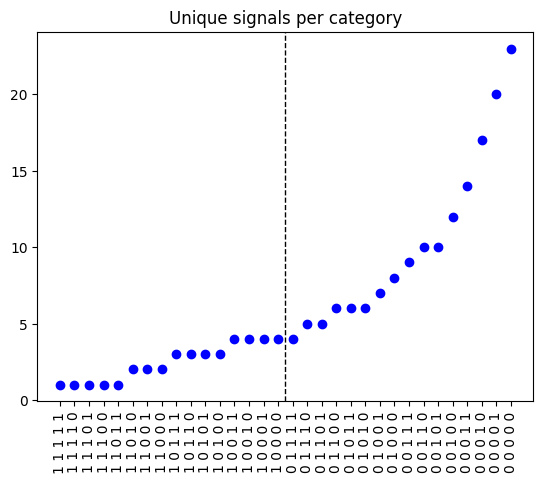

In [ ]:
import matplotlib.pyplot as plt

x = my_df["cat"].unique()
y = my_df.groupby('cat')['msg'].nunique().sort_values()
plt.plot(x,y, 'bo')
plt.xticks(rotation=90)
plt.title("Unique signals per category")
x_min, x_max = plt.xlim()
midpoint = (x_min + x_max) / 2
plt.axvline(x=midpoint, color='black', linestyle='--', linewidth=1)
plt.show()

## Processing data [REVISE NOTE]

`Preprocessor` ingests a two-column `pandas.DataFrame` (signals, categories), filters out categories that have fewer than *k* unique signal types, optionally prepends n-1 BOStr tokens to each signal (and EOSeq at then end of the sequence), shuffles the resulting list, and converts whitespace-separated integer tokens to a flat integer sequence.
These serve as input to the downstream n-gram model (`Ngram` class); shuffling improves inspection and histogram stability but, thanks to order-invariant counting, leaves probabilities unchanged.

### Preprocessor class

In [ ]:
import random

class Preprocessor:
    """
    Prepares a list of tokenized signals for language modeling.
    Filters out categories whose number of unique signal types is below a threshold.
    Optionally shuffles and converts strings to a flat integer sequence.
    Requires pandas, random.
    Attributes:
        _threshold (int): minimum number of unique message types per semantic category.
        _n_pad (int or None): if set to n, pads the messages with n-1 tokens.
        _padding (int or string): token used for padding.
        groups (dict or None): raw grouped messages by category.
        filtered (dict or None): messages after thresholding.
        signals (list or None): flat list of string signals.
        sequence (list or None): flat processed integer sequence.
    Methods:
        process: full pipeline execution.
        recompute: triggers processing and stores sequence.
        summary: prints config.
        set_threshold: updates threshold and marks state.
    """
    def __init__(self, min_signals: int, n_pad: int|None=2, padding:int|str=-1):
        if n_pad is not None and n_pad < 1:
            raise ValueError("n_pad must be None or ≥ 1")
        self._threshold = min_signals
        self._n_pad = n_pad
        self._padding = str(padding)
        self.groups = None
        self.filtered = None
        self.signals = None
        self.sequence = None

    def __call__(self, dataframe):
        return self.process(dataframe)

    def __repr__(self):
        return f"<Preprocessor: threshold={self._threshold}, n_pad={self._n_pad}, padding={self._padding}>"

    def set_min_signals(self, val):
        self._threshold = val

    def recompute(self, dataframe, shuffle=False):
        self.signals = self.process(dataframe, shuffle=shuffle, integers=False)
        self.sequence = self.strings_to_integers(self.signals) if integers else self.signals

    def summary(self):
        print(f"Threshold: {self._threshold}, n_pad: {self._n_pad}, padding: {self._padding}")
        print(f"Signals: {len(self.signals) if self.signals else 'N/A'}")

    def group_messages_by_cat(self, dataframe):
        """
        Groups messages by their associated category.
        - dataframe: pandas DataFrame containing 'msg' (signals) and 'cat' columns,
        in that order, with or without a header.
        Returns a dict of {category: [messages]}.
        """
        df = dataframe.iloc[:, :2].rename(columns={0: "msg", 1: "cat"})
        groups = df.groupby('cat')['msg'].apply(list)
        return groups.to_dict()

    def filter_unique_signals(self, groups):
        """
        Removes categories with unique signal types below the threshold.
        - groups: dict of {category: [signals]}
        - threshold: minimum number of unique signal types
        Returns a dict of {category: [signals]}.
        """
        return {k: v for k, v in groups.items() if len(set(v)) >= self._threshold}

    def convert_dict_to_list(self, groups):
        """
        Converts a dictionary of signals to a single list.
        - groups: dict of {category: [signals]}
        Returns a list of all signals.
        """
        return [sg for signals in groups.values() for sg in signals]

    def pad_signals(self, signals: list[str]) -> list[str]:
        """
        Insert (n_pad-1) copies of the padding token:
        once at the beginning of the dataset,
        once after every signal.
        No change if n_pad is None or <= 1.
        """
        if not self._n_pad or self._n_pad <= 1:
            return signals[:]
        k = self._n_pad - 1
        pad_block = " ".join([str(self._padding)] * k)
        return [pad_block] + [f"{sg} {pad_block}" for sg in signals]

    def shuffle_dataset(self, signals: list[str], seed: int|None=None) -> list[str]:
        """
        Shuffles a list of signals.
        - signals (list): the dataset to shuffle.
        Returns a list of signals.
        """
        shuffled = signals[:]
        rng = random.Random(seed)
        random.shuffle(shuffled)
        return shuffled

    def strings_to_integers(self, signals: list[str]) -> list[int]:
        """
        Maps every whitespace-separated token to an int.
        Numeric strings -> direct int cast
        Non-numeric  -> token2id
        """
        token2id: dict[str, int] = {}
        next_id = 0
        sequence: list[int] = []

        for sg in signals:
            for tok in sg.split():
                if tok.lstrip("-").isdigit(): # handles negative ints
                    sequence.append(int(tok))
                else:
                    if tok not in token2id:
                        token2id[tok] = next_id
                        next_id += 1
                    sequence.append(token2id[tok])
        return sequence

    def process(self, dataframe, shuffle=True, integers=True):
        """
        Applies all methods to the data in recommended order.
        Returns a list of signals.
        """
        groups = self.group_messages_by_cat(dataframe)
        filtered = self.filter_unique_signals(groups)
        signals = self.convert_dict_to_list(filtered)
        if shuffle:
            signals = self.shuffle_dataset(signals, seed=42)
        if self._n_pad is not None:
            signals = self.pad_signals(signals)
        self.signals = signals # store raw
        return (self.strings_to_integers(signals)
                if integers else signals)

### Tests

Test that the `Preprocessor` correctly transforms the data into a single list of `int` and pads on both sides with `-1`.

In [ ]:
def test_preprocessor_with_header():
    test_data = {'msg': ['1 2 3', '4 5 6', '7 8 9', '10 11 12', '13 14 15', '16 17 18', '19 20 21'],
            'cat': ['A', 'A', 'B', 'B', 'C', 'C', 'C']}
    test_df = pd.DataFrame(test_data)

    prep = Preprocessor(min_signals=1, n_pad=2)
    result = prep.process(test_df, shuffle=False)
    padded_signals = ['-1 ' + sg for sg in ['1 2 3', '4 5 6', '7 8 9', '10 11 12', '13 14 15', '16 17 18', '19 20 21']] + [' -1']
    expected = []
    for sg in padded_signals:
        expected.extend([int(x) for x in sg.split()])

    assert result == expected, f'Expected {expected}, got {result}'
    assert result == expected, f'Expected {expected}, got {result}'
    print('Preprocessor with header passed')

test_preprocessor_with_header()

Preprocessor with header passed


In [ ]:
def test_preprocessor_without_header():
    test_data = [
        ['1 2 3', 'A'],
        ['4 5 6', 'A'],
        ['7 8 9', 'B'],
        ['10 11 12', 'B'],
        ['13 14 15', 'C'],
        ['16 17 18', 'C'],
        ['19 20 21', 'C']
    ]
    test_df = pd.DataFrame(test_data)

    prep = Preprocessor(min_signals=1)
    groups = prep.group_messages_by_cat(test_df)

    expected_groups = {
        'A': ['1 2 3', '4 5 6'],
        'B': ['7 8 9', '10 11 12'],
        'C': ['13 14 15', '16 17 18', '19 20 21']
    }
    assert groups == expected_groups, f'Expected {expected_groups}, got {groups}'
    print('Preprocessor without header passed')

test_preprocessor_without_header()

Preprocessor without header passed


In [ ]:
prep = Preprocessor(min_signals=1, n_pad=3, padding=-1)
prep.process(my_df)
print(prep.signals[:5]) # first padding token is there
print(prep.summary())
del prep

['-1 -1', '12 4 0 -1 -1', '12 1 0 -1 -1', '4 4 4 4 4 0 -1 -1', '1 1 1 1 1 0 -1 -1']
Threshold: 1, n_pad: 3, padding: -1
Signals: 8193
None


# Model (modified version of an anterior Ngram class)

## N-gram Counting Model

`Ngram` class. We implement a modified n-gram language model with L2R and R2L counting using Laplace smoothing and metrics for language modelling, built by Chenyu Li (as of April 2025, LLF).

1. Training `train(self, tokens)` processes a sequence of tokens to count n-grams and build a context-to-token frequency map  
$$
\text{context}=(x_{t-n+1},\dots,x_{t-1}), \quad \text{token}=x_t
$$  
Counts are stored as `_count[context][token]+=1`  
In n-gram models, downstream tasks and evaluations generally assume that the context is in natural (left-to-right) order.  
As this affects the meaning and statistical counts, `._get_gram()` yields R2L contexts in left-to-right order.

2. The conditional probability `get_probability_distribution(self, context)` of a token \( w \) given context \( c \), using additive smoothing \( \alpha > 0 \)  
$$
P(w \mid c) = \frac{\text{count}(c, w) + \alpha}{\sum_{w'} \text{count}(c, w') + \alpha \cdot |V|}
$$  
If the context is unseen, a uniform distribution is returned  
$$
P(w \mid \text{unseen context}) = \frac{1}{|V|}
$$

3. `get_probability(context, token)` returns:  
$$
P(\text{token} \mid \text{context})
$$  
If the token is out-of-vocabulary, it returns \( 0.0 \).

4. Surprisal `get_surprisal(context, token)` returns the negative log likelihood of a token given its context  
$$
\text{Surprisal}(w \mid c) = -\log P(w \mid c)
$$  
Intuitively, it quantifies how unexpected (surprising) it is to see a given token follow the given context.

5. Entropy `get_entropy(context)` quantifies the average amount of information (here: nats) produced by a random data source. Intuitively, it is higher the more uncertain the outcome. For the probability of a token \( w \) following the context \( c \), the entropy \( H \) of \( c \) is  
$$
H(c) = - \sum_w P(w \mid c) \cdot \log P(w \mid c)
$$  
Tokens predictably following a context can be said to contribute less information, while rare outcomes contribute more. Entropy is highest when all outcomes are equally likely, therefore indicating maximum uncertainty.

6. Perplexity `get_perplexity(tokens)` the exponentiated average surprisal over a sequence of tokens of length \( N \)  
$$
\text{Perplexity}(x_{1:N}) = \exp\left( - \frac{1}{N} \sum_t \log P(x_t \mid x_{t-n+1:t-1}) \right)
$$  
Measures model uncertainty over whole sequences. Lower values indicate more confident and accurate predictions.

### Definition

In [ ]:
from nltk import ngrams
from collections import defaultdict, Counter
import numpy as np
from tqdm import tqdm

class Ngram:
    '''
    A token n-gram model with Laplace smoothing.

    Attributes:
        _n (int): Size of the n-gram.
        _smoothing (float): additive smoothing constant.
        _l2r (bool): count in left-to-right (True) or right-to-left (False) fashion.
        _count (defaultdict): frequencies {context: {token: count}}.
        _vocabulary (set): unique tokens observed during training.
        _probability (dict): smoothed probability table {context: {token: prob}}.

    Methods:
        train: trains the model on token sequences.
        reset: clears all learned statistics.
        summary: prints model configuration and stats.
        get_probability: P(token | context)
        get_surprisal: -log P(token | context)
        get_entropy: H(context)
        get_perplexity: evaluates sequence perplexity.
        get_vocabulary: returns set of observed tokens.
        set_smoothing: updates smoothing and recomputes probabilities.
    """
    '''

    def __init__(self, n, smoothing_constant=0.01, l2r=True):
        '''Smoothing <= 0 is coerced to 0.01'''
        self._n = n
        if(smoothing_constant <= 0): self._smoothing = 0.01; print(f"Smoothing must be >0; defaulting to {self._smoothing}.")
        else: self._smoothing = smoothing_constant
        self._count = defaultdict(lambda: defaultdict(int))
        self._vocabulary = set()
        self._probability = {}
        self._l2r = l2r

    def __repr__(self):
        return f"<Ngram(n={self._n}, l2r={self._l2r}, vocab={len(self._vocabulary)})>"

    def _get_uniform_distribution(self):
        '''
        Returns a uniform probability distribution over the vocabulary.
        '''
        return {} if not self._vocabulary else {w: 1.0 / len(self._vocabulary) for w in self._vocabulary}

    def _get_gram(self, tokens):
        '''Yields (context, token) where context is a tuple of n-1 tokens.'''
        all_grams = ngrams(tokens, self._n)
        for gram in all_grams:
            if self._l2r:
                context = gram[:-1]
                token = gram[-1]
            else:
                context = gram[1:]
                token = gram[0]
            yield (context, token)

    def _num_ngrams(self, tokens):
        '''Return the number of n-grams that can be formed from tokens.'''
        return max(0, len(tokens) - self._n + 1)

    def _flatten_tokens(self, tokens):
        '''If tokens is a list of lists, it is flattened.'''
        return [t for seq in tokens for t in seq] if tokens and isinstance(tokens[0], list) else tokens

    def _compute_probabilities(self, use_tqdm=False):
        '''
        Probabilities (for contexts, not raw tokens) are computed with additive smoothing:
        P(w|context) = (count + smoothing) / (total + smoothing * |V|)
        '''
        V = len(self._vocabulary)
        # Loop over every context in the count dictionary
        keys = self._count.keys()
        iter = tqdm(keys, desc="Calculating probability", total=len(keys)) if use_tqdm else keys
        for context in iter:
            # Compute the total number of times any token follows context
            occ_context = sum(self._count[context].values())
            # Unseen tokens get non-zero probability
            self._probability[context] = defaultdict(lambda: self._smoothing / (occ_context + self._smoothing * V))
            for token, count in self._count[context].items():
                self._probability[context][token] = (count + self._smoothing) / (occ_context + self._smoothing * V)

    def summary(self):
        print("Ngram Model Configuration:")
        print(f"  n:             {self._n}")
        print(f"  l2r:           {self._l2r}")
        print(f"  smoothing:     {self._smoothing}")
        print(f"  vocabulary:    {len(self._vocabulary)} types")
        print(f"  contexts:      {len(self._count)} unique contexts")

    def train(self, tokens, use_tqdm=False):
        '''
        Trains the n-gram model on the input tokens.
        - tokens (list or list[list]): an iterable of tokens.
        - use_tqdm (bool): show progress bar.
        '''
        tokens = self._flatten_tokens(tokens)  # Flatten if tokens is a list of lists
        total_grams = self._num_ngrams(tokens) # Number of possible grams
        iter = self._get_gram(tokens)

        if use_tqdm: # Show progress bar
            iter = tqdm(iter, desc="Counting", total=total_grams)

        for context, token in iter:
            self._count[context][token] += 1
            self._vocabulary.add(token)

        self._compute_probabilities(use_tqdm=use_tqdm)

    def reset(self):
        '''
        Clears counts, probas, and vocabulary.
        '''
        self._count = defaultdict(lambda: defaultdict(int))
        self._probability = {}
        self._vocabulary = set()

    def get_probability_distribution(self, context):
        '''
        Returns probability distribution for a given context.
        - context (tuple): context tokens
        '''
        return self._probability.get(context, self._get_uniform_distribution())

    def get_probability(self, context, token):
        '''
        Return the probability of a token given the context.
        - token: everyone knows what a horse is
        If the token isn't in the context, return "fallback" smoothed probability.
        '''
        if(token not in self._vocabulary): return 0.0
        dist = self.get_probability_distribution(context)
        # If token is not present, use default smoothing value
        fallback = self._smoothing / (sum(self._count.get(context, {}).values()) + self._smoothing * len(self._vocabulary))
        return dist.get(token, fallback)

    def get_surprisal(self, context, token):
        '''
        Computes the surprisal (negative log likelihood) for a token given the context.
        - context: tuple of tokens
        - token: token for which to compute surprisal
        '''
        return -np.log(self.get_probability(context, token))

    def get_entropy(self, context):
        '''
        Computes entropy for a given context.
        '''
        dist = self.get_probability_distribution(context)
        return -sum(p * np.log(p) for p in dist.values())

    def get_perplexity(self, tokens, use_tqdm=False):
        '''
        Computes the perplexity on a sequence of tokens.
        - tokens: iterable of tokens (e.g. list of integers/strings)
        '''
        tokens = self._flatten_tokens(tokens) # Flatten if tokens is a list of lists
        total_grams = self._num_ngrams(tokens)
        log_prob = 0.0
        iter = self._get_gram(tokens)
        if use_tqdm:
            iter = tqdm(iter, total=total_grams, desc="Calculating perplexity")
        for context, token in iter: # Sum log probas for each n-gram prediction
            log_prob += np.log(self.get_probability(context, token))
        return np.exp(-log_prob / total_grams if total_grams > 0 else 1)

    def get_vocabulary(self):
        '''
        Returns the set of tokens in the vocabulary.
        '''
        return self._vocabulary

    def set_smoothing(self, smoothing_constant):
        '''
        Updates the smoothing constant.
        '''
        self._smoothing = smoothing_constant
        self._compute_probabilities()

### Tests

Test context yield

In [ ]:
import numpy as np
from collections import Counter

def test_context_yield():
    chain = "abacabadabaeaba"
    n = 3

    # Train L2R and R2L models on the same string
    model_l2r = Ngram(n=n, smoothing_constant=1)
    model_r2l = Ngram(n=n, smoothing_constant=1, l2r=False)
    model_l2r.train(chain)
    model_r2l.train(chain)

    # Vocabulary equality
    assert model_l2r.get_vocabulary() == model_r2l.get_vocabulary()

    # Expected (context, token) pairs
    # Build gold lists once
    gold_grams = [tuple(chain[i : i + n]) for i in range(len(chain) - n + 1)]

    expected_l2r = [ (g[:-1], g[-1])          for g in gold_grams ]
    expected_r2l = [ (g[1:],  g[0])           for g in gold_grams ]

    assert list(model_l2r._get_gram(chain)) == expected_l2r
    assert list(model_r2l._get_gram(chain)) == expected_r2l

    # Count dictionary matches reference
    # Re-count with pure Python for cross-check
    ref_counter = Counter()
    for ctx, tok in expected_l2r:
        ref_counter[(ctx, tok)] += 1

    for ctx, tok_counts in model_l2r._count.items():
        for tok, c in tok_counts.items():
            assert ref_counter[(ctx, tok)] == c

    # Probability mass sums to 1 (must include unseen tokens)
    V = model_l2r.get_vocabulary()
    for ctx in model_l2r._probability.keys():
        total = sum(model_l2r.get_probability(ctx, tok) for tok in V)
        assert np.isclose(total, 1.0)

test_context_yield()

Test smoothing, retraining

In [ ]:
import numpy as np
from collections import defaultdict

def test_smoothing_edgecases():
    chain   = "abacabadabaeaba"
    n       = 3
    ctx     = ('a', 'b')
    V       = len(set(chain))

    # Negative alpha coerced
    model_bad = Ngram(n, smoothing_constant=-2)
    assert model_bad._smoothing == 0.01

    # Tiny alpha vs alpha = 1
    tiny = 1e-6
    m_tiny = Ngram(n, smoothing_constant=tiny)
    m_one  = Ngram(n, smoothing_constant=1)
    m_tiny.train(chain)
    m_one.train(chain)

    # Count occurrences programmatically
    def count_ctx_next(seq, n, ctx):
        totals = defaultdict(int)
        for i in range(len(seq) - n + 1):
            if tuple(seq[i : i+n-1]) == ctx:
                totals[seq[i+n-1]] += 1
        return totals, sum(totals.values())

    next_counts, tot_ctx = count_ctx_next(chain, n, ctx)   # tot_ctx = 4
    c_a = next_counts.get('a', 0)

    # Laplace expectations
    p_tiny  = (c_a + tiny) / (tot_ctx + tiny * V)
    p_one_a = (c_a + 1)    / (tot_ctx + 1 * V)
    p_one_c = (next_counts.get('c', 0) + 1) / (tot_ctx + 1 * V)

    assert np.isclose(m_tiny.get_probability(ctx, 'a'), p_tiny)
    assert np.isclose(m_one .get_probability(ctx, 'a'), p_one_a)
    assert np.isclose(m_one .get_probability(ctx, 'c'), p_one_c)

    # set_smoothing recomputes
    m_tiny.set_smoothing(1)
    assert np.isclose(m_tiny.get_probability(ctx, 'a'), p_one_a)

    # Unseen context uniform
    unseen = ('x', 'y')
    uni = m_one.get_probability_distribution(unseen)
    assert np.isclose(sum(uni.values()), 1.0)
    assert all(np.isclose(p, 1 / V) for p in uni.values())

test_smoothing_edgecases()

Smoothing must be >0; defaulting to 0.01.


Test entropy, perplexity behaves predictably for L2R, R2L

In [ ]:
def test_entropy_perplexity_l2r_r2l():
    # ---------- L2R trigram model ----------
    model = Ngram(n=2, smoothing_constant=1)
    model.train("abababac")

    # Probabilities
    assert model.get_probability(('a',), 'b') == 4/7
    assert model.get_probability(('a',), 'c') == 2/7
    assert model.get_probability(('b',), 'a') == 2/3

    # Entropy
    Ha = -(4/7)*np.log(4/7) - (2/7)*np.log(2/7)
    assert np.isclose(model.get_entropy(('a',)), Ha)

    # Perplexity on "abc"
    p = (4/7) * (1/6)                 # P(b|a) * P(c|b)
    expected_pp = np.power(1/p, 1/2)  # two bigrams -> exponent 1/2
    assert np.isclose(model.get_perplexity('abc'), expected_pp)

    # Uniform fallback for unseen context
    assert model.get_probability_distribution(('d',)) == \
           {w: 1/3 for w in model.get_vocabulary()}   # |V| = 3

    # ---------- R2L bigram model ----------
    model_r = Ngram(n=2, smoothing_constant=1, l2r=False)
    model_r.train("cabababa")

    # Same probability checks still hold (symmetrical sequence)
    assert model_r.get_probability(('a',), 'b') == 4/7
    assert model_r.get_probability(('a',), 'c') == 2/7
    assert model_r.get_probability(('b',), 'a') == 2/3

## Initialization pipeline with upstream `Preprocessor`

In [ ]:
def build_ngram_model(df, min_signals, n, smoothing_constant, l2r=True, tqdm=False, shuffle=False):
    """
    Preprocesses a token dataset and trains an Ngram model with smoothing and directional control.
    Returns the processed token sequence and the trained model.
    """
    data = Preprocessor(min_signals=min_signals, n_pad=n).process(df, shuffle=shuffle)
    gram = Ngram(n=n, smoothing_constant=smoothing_constant, l2r=l2r)
    gram.train(data, use_tqdm=tqdm)
    return data, gram

### Tests

In [ ]:
import numpy as np
from collections import Counter

def check_model_pair(tokens, n, alpha):
    """Build L2R & R2L models and run consistency checks."""
    m_l2r = Ngram(n, smoothing_constant=alpha, l2r=True)
    m_r2l = Ngram(n, smoothing_constant=alpha, l2r=False)
    m_l2r.train(tokens)
    m_r2l.train(tokens)

    # The two models see the same n-gram windows
    grams_l = list(m_l2r._get_gram(tokens))
    grams_r = list(m_r2l._get_gram(tokens))
    canon_l = [tuple(list(ctx) + [tok]) for ctx, tok in grams_l]
    canon_r = [tuple([tok] + list(ctx)) for ctx, tok in grams_r]

    assert Counter(canon_l) == Counter(canon_r)

    # Count tables internally consistent
    for ctx_l, tok_counts in m_l2r._count.items():
        for tok, c in tok_counts.items():
            canonical = tuple(list(ctx_l) + [tok])
            assert Counter(canon_l)[canonical] == c

    # Probability mass sums to 1
    V = m_l2r.get_vocabulary()
    for ctx in m_l2r._probability:
        total = sum(m_l2r.get_probability(ctx, w) for w in V)
        assert np.isclose(total, 1.0)

    for ctx in m_r2l._probability:
        total = sum(m_r2l.get_probability(ctx, w) for w in V)
        assert np.isclose(total, 1.0)

    # Perplexity identical
    pp_l = m_l2r.get_perplexity(tokens)
    pp_r = m_r2l.get_perplexity(tokens)
    assert np.isclose(pp_l, pp_r)

def test_alignment_and_contexts():
    # n = 2
    data2_l, _ = build_ngram_model(my_df, 1, 2, 1.0, l2r=True)
    data2_r, _ = build_ngram_model(my_df, 1, 2, 1.0, l2r=False)
    assert data2_l == data2_r
    check_model_pair(data2_l, n=2, alpha=1.0)

    # n = 3
    data3_l, _ = build_ngram_model(my_df, 1, 3, 1.0, l2r=True)
    data3_r, _ = build_ngram_model(my_df, 1, 3, 1.0, l2r=False)
    assert data3_l == data3_r
    check_model_pair(data3_l, n=3, alpha=1.0)

test_alignment_and_contexts()

## Distribution

The distribution of entropy and surprisal values is informative at this point; since we padded every signal with `-1`, the entropy for end-of-string pairs '`x 0`' will always drop to low values, expecting `-1`, and rise at subword boundary. On the other hand, if a sequence is the beginning of a string or subword, surprisal should peak. Perplexity is not used in this experience, but given for information.

To sort the plot values by decreasing order, change the `sort_by` argument to `"value"`.

### Metric plotting methods

In [ ]:
def plot_ngram_entropy(model, data, sort_by="context"):
    from collections import Counter

    ctx_counts = Counter(ctx for ctx, _ in model._get_gram(data))
    entropies = {ctx: model.get_entropy(ctx) for ctx in ctx_counts}

    if sort_by == "value":
        sorted_items = sorted(entropies.items(), key=lambda x: x[1], reverse=True)
    elif sort_by == "frequency":
        sorted_items = sorted(entropies.items(), key=lambda x: ctx_counts[x[0]], reverse=True)
    elif sort_by == "context":
        sorted_items = sorted(entropies.items(), key=lambda x: x[0])
    else:
        raise ValueError("Choose from 'value', 'frequency', or 'context'")

    labels, values = zip(*sorted_items)
    freqs = [ctx_counts[ctx] for ctx in labels]
    labels_str = [f"{ctx} (occ={f})" for ctx, f in zip(labels, freqs)]

    plt.figure(figsize=(6, 18))
    plt.barh(range(len(labels_str)), values)
    plt.yticks(range(len(labels_str)), labels_str)
    plt.xlabel("Entropy")
    plt.title(f"Entropy per Context (sorted by {sort_by})")
    plt.margins(y=0)
    plt.tight_layout()
    plt.show()

def plot_ngram_surprisal(model, data, sort_by="token"):
    from collections import Counter

    ctx_tok_pairs = list(model._get_gram(data))
    freq = Counter(ctx_tok_pairs)
    surprisal = {(ctx, tok): model.get_surprisal(ctx, tok) for ctx, tok in ctx_tok_pairs}

    if sort_by == "value":
        sorted_items = sorted(surprisal.items(), key=lambda x: x[1], reverse=True)
    elif sort_by == "frequency":
        sorted_items = sorted(surprisal.items(), key=lambda x: freq[x[0]], reverse=True)
    elif sort_by == "token":
        sorted_items = sorted(surprisal.items(), key=lambda x: x[0][1])
    else:
        raise ValueError("Choose from 'value', 'frequency', or 'token'")

    labels, values = zip(*sorted_items)
    freqs = [freq[(ctx, tok)] for (ctx, tok) in labels]
    labels_str = [f"{ctx}:{tok} (occ={f})" for (ctx, tok), f in zip(labels, freqs)]

    plt.figure(figsize=(6, 18))
    plt.barh(range(len(labels_str)), values)
    plt.yticks(range(len(labels_str)), labels_str)
    plt.xlabel("Surprisal")
    plt.title(f"Surprisal per (Context: Token) (sorted by {sort_by})")
    plt.margins(y=0)
    plt.tight_layout()
    plt.show()

def plot_ngram_perplexity(model, data, window=3, sort_by="first_token"):
    from collections import Counter

    sequences = [tuple(data[i:i+window]) for i in range(len(data) - window + 1)]
    freq = Counter(sequences)
    perplexities = {seq: model.get_perplexity(seq, use_tqdm=False) for seq in sequences}

    if sort_by == "value":
        sorted_items = sorted(perplexities.items(), key=lambda x: x[1], reverse=True)
    elif sort_by == "frequency":
        sorted_items = sorted(perplexities.items(), key=lambda x: freq[x[0]], reverse=True)
    elif sort_by == "first_token":
        sorted_items = sorted(perplexities.items(), key=lambda x: x[0][0])
    else:
        raise ValueError("Choose from 'value', 'frequency', or 'first_token'")

    labels, values = zip(*sorted_items)
    freqs = [freq[seq] for seq in labels]
    labels_str = [f"{''.join(map(str, seq))} (occ={f})" for seq, f in zip(labels, freqs)]

    plt.figure(figsize=(6, 18))
    plt.barh(range(len(labels_str)), values)
    plt.yticks(range(len(labels_str)), labels_str)
    plt.xlabel("Perplexity")
    plt.title(f"Perplexity per Sequence (sorted by {sort_by})")
    plt.margins(y=0)
    plt.tight_layout()
    plt.show()

Pick up data:

In [ ]:
data, gram = build_ngram_model(my_df, min_signals=1, n=3, smoothing_constant=0.01, l2r=True, tqdm=False)

### Entropy

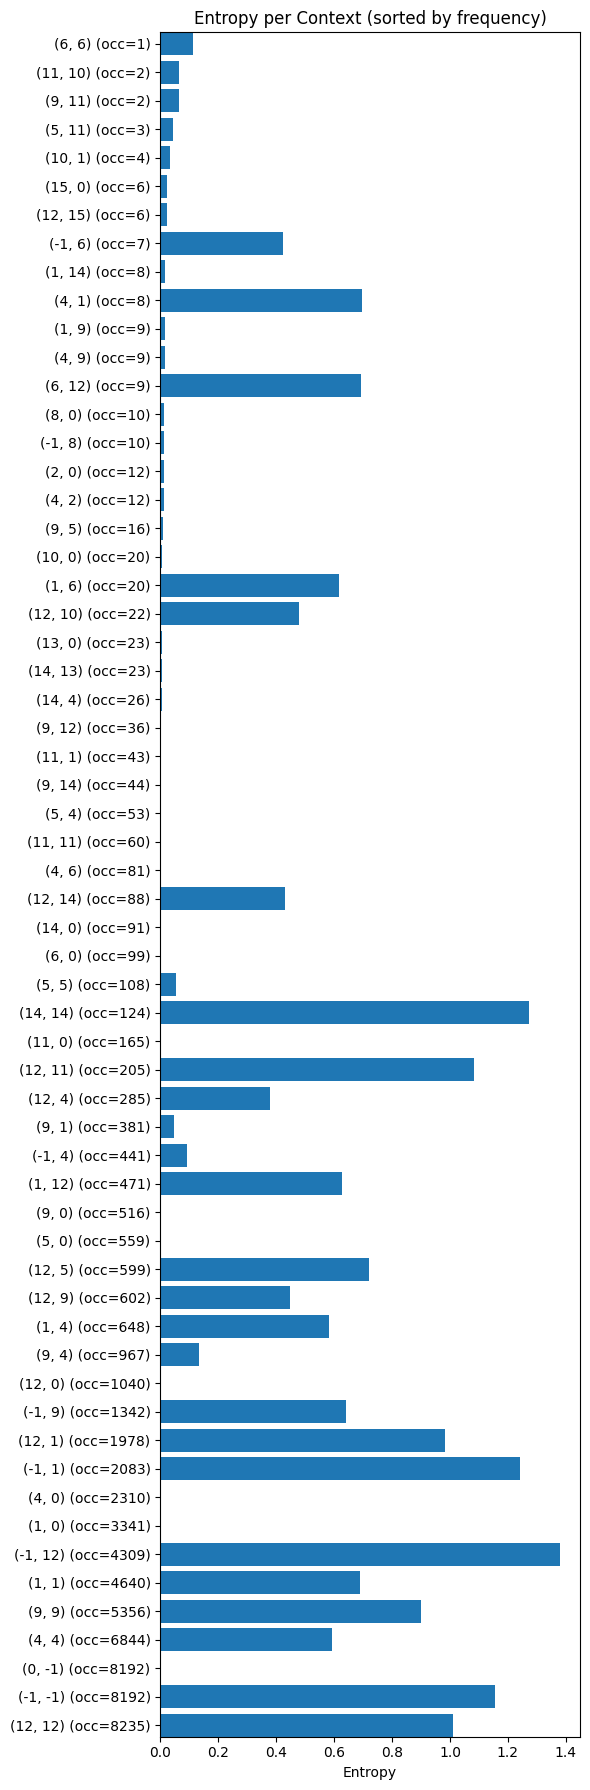

In [ ]:
plot_ngram_entropy(gram, data, sort_by='frequency')

### Surprisal

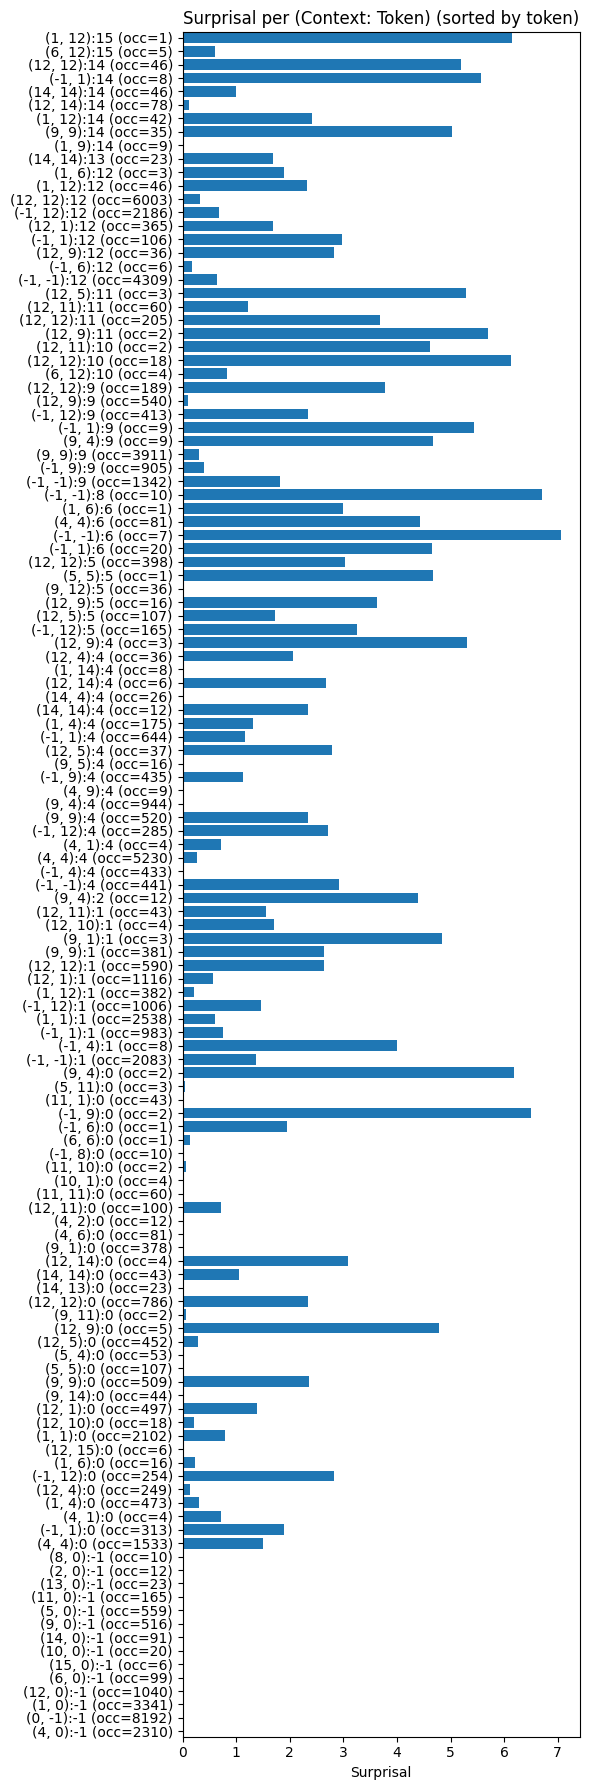

In [ ]:
plot_ngram_surprisal(gram, data, sort_by='token')

### Perplexity

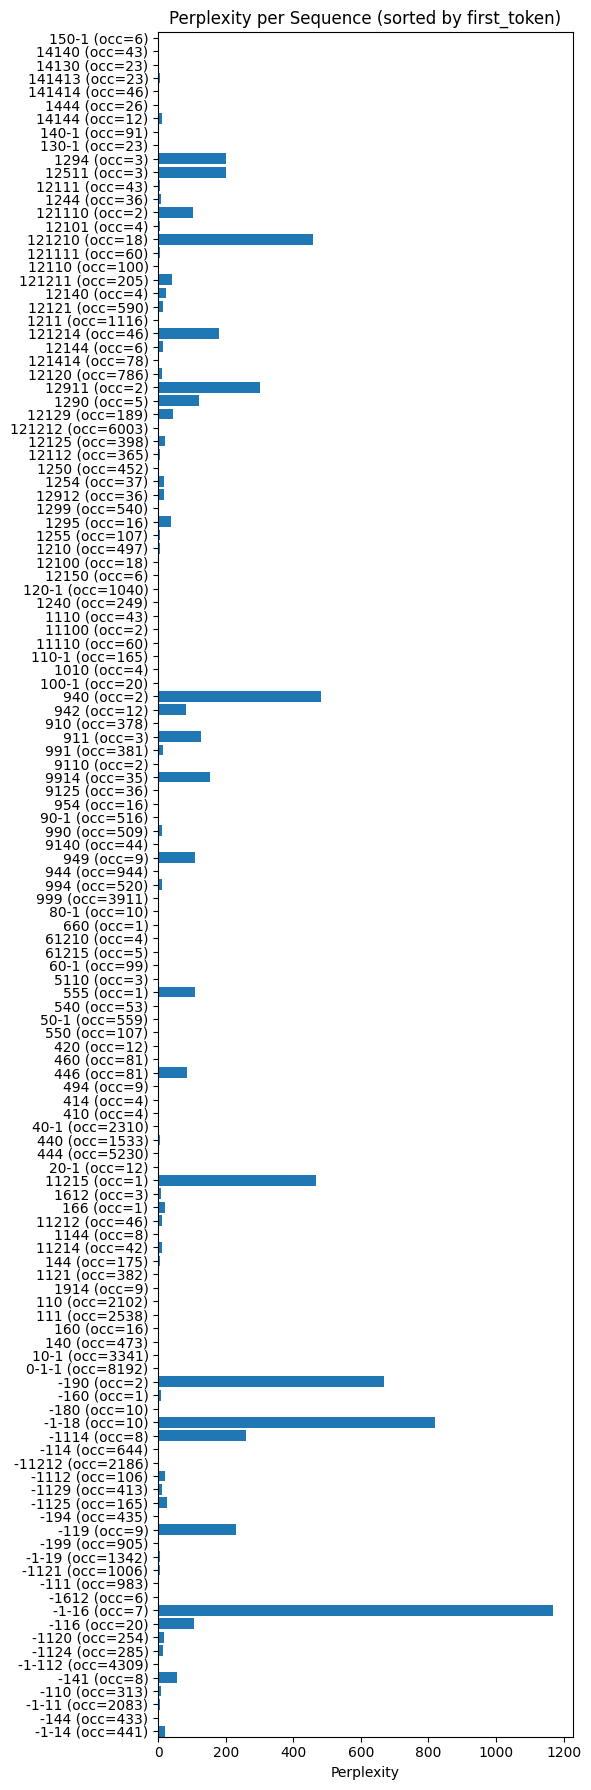

In [ ]:
plot_ngram_perplexity(gram, data, window=3, sort_by='first_token')

# Data Exports + Visualisations

## DataFrames and Exports

### Making DataFrames I: For a given direction and n-gram

In [ ]:
def build_ngram_dataframe(ngram_model):
    '''
    ngram_model (Tuple): output of the Preprocessor and Ngram classes in that order, for the same setup
    '''
    data, gram = ngram_model
    grams = list(gram._get_gram(data))

    df = pd.DataFrame({
        "Context": [context for context, token in grams],
        "Token": [token for context, token in grams],
        "Left-to-right Entropy": [gram.get_entropy(context) for context, token in grams],
        "Left-to-right Surprisal": [gram.get_surprisal(context, token) for context, token in grams],
    })

    return df

```
from IPython.display import display
display(df.head(9))
```

### Making DataFrames II: Both directions aligned around key token

The function `align_metrics` compares the output of two directional n-gram models (left-to-right and right-to-left where n(L2R)=n(R2L)) by evaluationg each token in a sequence using its surrounding context: using n-1 preceding tokens for L2R, and n-1 following tokens for R2L. Importantly, both models use contexts in their natural (L2R) order. In R2L, this is achieved by reversing the context window at training time but preserving L2R order during evaluation, ensuring consistent representation and indexing across both models.

To ensure valid comparisons, the function skips by default token positions where a full context cannot be formed in either direction (near sequence boundaries). For each valid position, it computes the selected metrics using both models and stores the result in the corresponding row. The resulting DataFrame preserves the original token sequence and aligns metric values **per token**, enabling clear analysis for directional asymmetries and supporting downstream tasks.

In [ ]:
import pandas as pd

def align_metrics(tokens: list|tuple, left_ngram, right_ngram, metrics: list|tuple = ("entropy",),
                  incomplete_contexts: bool = False, match_vocab: bool = False) -> pd.DataFrame:
    """
    Aligns directional metrics (entropy, surprisal, probability) from a
    L2R and R2L n-gram model over the same token sequence.
    - tokens: tokens in L2R order
    - left_ngram: trained L2R n-gram model
    - right_ngram: trained R2L n-gram model (same n)
    - metrics: any, two or all of:
        - 'entropy'     : entropy of context
        - 'surprisal'   : -log P(token | context)
        - 'probability' : P(token | context)
    - incomplete_contexts: if True, include boundary positions (with NaNs where needed)
    - match_vocab: if True, raise error if vocabularies differ
    Returns a DataFrame with:
    - 'Position': token index in the sequence
    - 'Token': the token at that index
    - 'L2R-context' and 'R2L-context': n–1 tokens before or after
    - 'L2R-<metric>' and 'R2L-<metric>': metric scores for each direction
    """
    # Check validity
    allowed = {"entropy", "surprisal", "probability"}
    unknown = set(metrics) - allowed
    if unknown:
        raise ValueError(f"Unsupported metrics {unknown}. Allowed: {allowed}")
    if left_ngram._n != right_ngram._n:
        raise ValueError("Both models must have the same n")
    if match_vocab and left_ngram.get_vocabulary() != right_ngram.get_vocabulary():
        raise ValueError("Model vocabularies differ")

    n = left_ngram._n
    ctx_size = n - 1
    seq_len = len(tokens)

    # Dispatch metrics: metric, context, token
    metric_fns = {
        "entropy":     lambda m, c, t: m.get_entropy(c),
        "surprisal":   lambda m, c, t: m.get_surprisal(c, t),
        "probability": lambda m, c, t: m.get_probability(c, t),
    }

    rows = []
    for i, tok in enumerate(tokens):
        left_ok  = i >= ctx_size
        right_ok = (i + ctx_size) < seq_len
        if not (left_ok and right_ok) and not incomplete_contexts:
            continue  # skip boundary token
        l_ctx = tuple(tokens[i - ctx_size : i])             if left_ok  else tuple()
        r_ctx = tuple(tokens[i + 1 : i + 1 + ctx_size])     if right_ok else tuple()
        row = {
            "Position":     i,
            "Token":        tok,
            "L2R-context":  l_ctx,
            "R2L-context":  r_ctx,
        }
        for name in metrics:
            row[f"L2R-{name}"] = metric_fns[name](left_ngram,  l_ctx, tok) if left_ok  else float("nan")
            row[f"R2L-{name}"] = metric_fns[name](right_ngram, r_ctx, tok) if right_ok else float("nan")
        rows.append(row)

    return pd.DataFrame(rows).sort_values("Position").reset_index(drop=True)

```
alpha = 0.01
data_2, gram_2l = build_ngram_model(my_df, 1, 2, smoothing_constant=alpha, l2r=True) # Data is the same for n-gram regardless of direction
data_2, gram_2r = build_ngram_model(my_df, 1, 2, smoothing_constant=alpha, l2r=False)
data_3, gram_3l = build_ngram_model(my_df, 1, 3, smoothing_constant=alpha, l2r=True)
data_3, gram_3r = build_ngram_model(my_df, 1, 3, smoothing_constant=alpha, l2r=False)
# Full DataFrame
df_aligned_2gram = align_metrics(data_2, gram_2l, gram_2r, metrics=("surprisal","entropy"))
df_aligned_3gram = align_metrics(data_3, gram_3l, gram_3r, metrics=("surprisal","entropy"))


In [ ]:
def add_delta_metrics(df):
    df["delta-surprisal"] = df["R2L-surprisal"] - df["L2R-surprisal"]
    df["delta-entropy"]   = df["R2L-entropy"]   - df["L2R-entropy"]
    return df

### Exporting DataFrames to Google Drive

DataFrames saved to https://drive.google.com/drive/folders/1QYAdhyFzwpNrlzSHYn_HQ0R8mgcp3l5n?usp=sharing

```
from google.colab import drive
import os
# Connect to Google Drive and save dataframes
drive.mount('/content/drive')
output_dir = "/content/drive/MyDrive/ngram_outputs"
os.makedirs(output_dir, exist_ok=True)

df_aligned_2gram.to_csv(os.path.join(output_dir, f"2gram_ambi_s{alpha}.csv"), index=False)
df_aligned_3gram.to_csv(os.path.join(output_dir, f"3gram_ambi_s{alpha}.csv"), index=False)
```

## Plotting Method

`visualize_results` plots selected language model metrics from a bidirectional DataFrame produced by `align_metrics`. It suggests an appropriate figure size for the slice of data selected (it is possible, albeit not practical, to plot the entire distribution).

In [ ]:
import matplotlib.pyplot as plt

def visualize_results(bi_df, slice_=None, figsize=(20,4), metrics=("surprisal","entropy"),
                      directions=("l2r", "r2l"), threshold=None):
    '''
    Plot selected metrics from a bidirectionnal DataFrame.
    bi_df (DataFrame): bidirectionnal DataFrame containing L2R and R2L metrics.
    slice: tuple of (start, end) indices.
    figsize: tuple of figure size.
    metrics: tuple of metric names.
    directions: tuple of directions to plot.
    threshold: add horizontal line at this value.
    '''

    if slice_ is not None:
        while not isinstance(slice_, tuple):
            print("Express slice as a (start, end) tuple.")
            return None
        start, end = slice_
        if end - start > 100:
            width = (end - start) / 5
            print(f"Warning! To generate {end - start} lines, set figsize to at least ({width:.0f}, 3).")
            user_response = input("Continue? Y/N: ")
            if user_response.strip().upper() != "Y":
                print("Aborted.")
                return None
        df = bi_df.iloc[start:end]
    else:
        print("Warning! Full DataFrame generation may take time.")
        user_response = input("Continue? Y/N: ")
        if user_response.strip().upper() != "Y":
            print("Aborted.")
            return None
        df = bi_df.copy()

    plt.figure(figsize=figsize)
    marker = None if len(df) > 100 else 'o'
    directions = [d.upper() for d in directions]

    colors = {"L2R-surprisal": "blue", "R2L-surprisal": "red",
              "L2R-entropy": "green", "R2L-entropy": "orange"}

    for direction in directions:
        for metric in metrics:
            colname = f"{direction}-{metric.lower()}"
            if colname in df.columns:
                plt.plot(df["Position"], df[colname], marker=marker,
                         color=colors.get(colname, None), label=colname, markersize=3)

    if threshold is not None:
        plt.axhline(y=threshold, color="gray", linestyle="--", linewidth=1, label=f"Threshold = {threshold}")

    plt.xticks(ticks=df["Position"], labels=df["Token"], rotation=45)
    plt.xlabel("Token Index in Sequence")
    plt.ylabel("Metric Value")
    plt.title("Metrics: " + ", ".join(metrics) + " (" + ", ".join(directions) + ")")
    plt.legend()
    plt.show()

# Demo

Calculating probability: 100%|██████████| 60/60 [00:00<00:00, 86480.49it/s]


,Position,Token,L2R-context,R2L-context,L2R-entropy,R2L-entropy,L2R-surprisal,R2L-surprisal,delta-surprisal,delta-entropy
0,2,1,"(-1, -1)","(1, 1)",1.153999,1.006274,1.369362,0.603366,-0.765996,-0.147725
1,3,1,"(-1, 1)","(1, 0)",1.243216,1.115541,0.751017,0.463421,-0.287596,-0.127675
2,4,1,"(1, 1)","(0, -1)",0.688735,1.578387,0.603366,0.896903,0.293537,0.889652
3,5,0,"(1, 1)","(-1, -1)",0.688735,0.000017,0.791853,0.000017,-0.791836,-0.688718
4,6,-1,"(1, 0)","(-1, 12)",0.000042,0.000032,0.000042,0.000032,-0.000009,-0.000009
5,7,-1,"(0, -1)","(12, 1)",0.000017,1.022278,0.000017,0.676170,0.676153,1.022261
6,8,12,"(-1, -1)","(1, 0)",1.153999,1.115541,0.642468,1.905460,1.262992,-0.038458
7,9,1,"(-1, 12)","(0, -1)",1.380117,1.578387,1.454749,0.896903,-0.557845,0.198270
8,10,0,"(12, 1)","(-1, -1)",0.981824,0.000017,1.381307,0.000017,-1.381290,-0.981806
9,11,-1,"(1, 0)","(-1, 9)",0.000042,0.000104,0.000042,0.000104,0.000062,0.000062


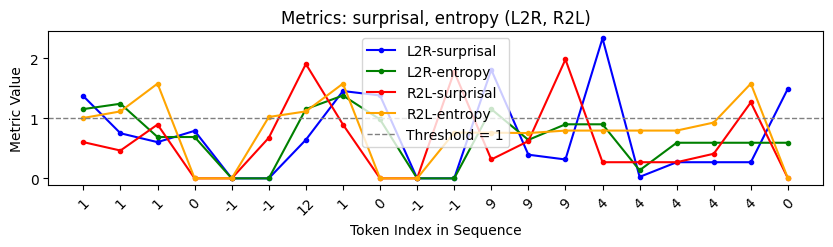

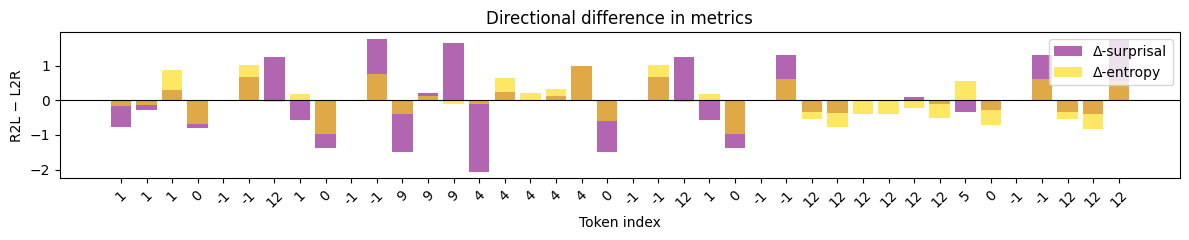

In [ ]:
# Select all signals in base DataFrame, with medium smoothing, and count both ways
tokens, left_Ngram = build_ngram_model(my_df, min_signals=1, n=3, smoothing_constant=0.01, l2r=True,  tqdm=True, shuffle=True)
_, right_Ngram     = build_ngram_model(my_df, min_signals=1, n=3, smoothing_constant=0.01, l2r=False, tqdm=True, shuffle=True)

# Create direction-specific DataFrames
#left_df  = build_ngram_dataframe(left_Ngram)
#right_df = build_ngram_dataframe(right_Ngram)

# Create DataFrame centered around the token predicted form either context
bi_df = align_metrics(tokens, left_ngram=left_Ngram, right_ngram=right_Ngram, metrics=('entropy', 'surprisal'))
bi_df = add_delta_metrics(bi_df)
# Show first 10 tokens
display(bi_df.head(10))

# Show first 10 tokens on a graph, with values for surprisal, entropy, both directions, and a line on median l2r entropy from the 10 tokens
visualize_results(bi_df, slice_=(0,20), figsize=(10,2), metrics=('surprisal', 'entropy'), directions=('l2r', 'r2l'), threshold=1)

# Δ-metrics barplot
fig, ax = plt.subplots(figsize=(12, 2.5), sharex=True)
slice_df = bi_df.iloc[0:40]
ax.bar(slice_df["Position"], slice_df["delta-surprisal"], color="purple", alpha=0.6, label="Δ-surprisal")
ax.bar(slice_df["Position"], slice_df["delta-entropy"],   color="gold",   alpha=0.6, label="Δ-entropy")
ax.axhline(0, color="black", linewidth=0.8)
ax.set_ylabel("R2L − L2R")
ax.set_xlabel("Token index")
ax.set_xticks(slice_df["Position"])
ax.set_xticklabels(slice_df["Token"], rotation=45)
ax.set_title("Directional difference in metrics")
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

# Tokenization

We tokenize the input--a sequence of tokens, and its corresponding bidirectional DataFrame--based on values of either surprisal or entropy assigned to the current token. Both the surprisal and the entropy tokenizer use the same strategy to assign boundaries on which the input will be cut, but differ in execution: in the first case, we cut when surprisal exceeds a threshold value input as a hyperparameter, while in the second case, we cut when the difference in entropy of the current and preceding tokens exceeds a certain value, also decided as a hyperparameter. Additionally, at this stage we remove the padding tokens, and optionally the 0 (the token ending every sequence) from the analysis.

### A note on the tokenization strategy

#### Choosing the threshold

Tokenization strictly depends on the threshold set by the user. There are at least two reasonable techniques to choose the threshold, both requiring some inspection on results before deciding the optimal value. In a further section, we also propose a search consisting in maximizing Mutual Information between token and expressed category.

The first technique is based in heuristics and consists in the observation of tokenization results. The user can try to identify informative patterns in the dataset by hand or using a brute force search. For example, in this dataset, we have observed that `5` always occurs before the sequence `5 0` or `0`, therefore suggesting that this pattern has some determined semantics among signals. <br>
We also suggest observing whether the tokenization yields a desirable vocabulary length or mean token length. Moreover, the tokenizer always returns the token dictionary and frequencies, which can support a brute-force search for informative patterns.

Another way of approaching boundary-setting is to treat each metric as a univariate distribution and pick a cutoff that isolates only the "tails" where boundaries are likely. In corpus work, fixed percentile and z-score/mean-absolute-deviation are common solutions for unsupervised approaches like here, where a gold segmentation is not available but we can infer the distribution.

For instance, the following code provides the surprisal cutoff for the L2R model, selecting the top 5% most-surprising tokens based on their surprisal distribution. Increasing `tail_frac` yields more segmentation points, while decreasing it yields fewer, letting the user tune boundary density. If entropy-jump is used, we can apply the same helper function to ΔH.

In [ ]:
def tail_threshold(arr, tail_frac=0.05):
    """Return the cutoff that leaves `tail_frac` highest values."""
    return np.quantile(arr, 1 - tail_frac)
surp_cut = tail_threshold(bi_df["L2R-surprisal"], 0.05)        # e.g. 95-th pct
dH_cut   = tail_threshold(np.abs(np.diff(bi_df["L2R-entropy"])), 0.05)

The following plot shows the results: the empirical cumulative distribution function of surprisal with the red vertical line marking the selected threshold. Tokens to the right of the line fall in the extreme tail and will trigger a boundary under the surprisal rule.

How to interpret different cases:
* a steep tail (curve rises sharply then flattens to the right-hand side) means only a few tokens exceed the cutoff, resulting in coarse segmentation;
* a flatter tail (curve increasing gradually) indicates many tokens above the cutoff, producing finer segmentation;
* a plateau before the red line means almost no tokens reach the cutoff (raise `tail_frac` or choose a lower percentile);
* red line close to 0.0 on the x-axis means the threshold is too low (decrease `tail_frac`).

Adjust tail_frac until the red line sits where the tail behaviour matches the desired granularity.

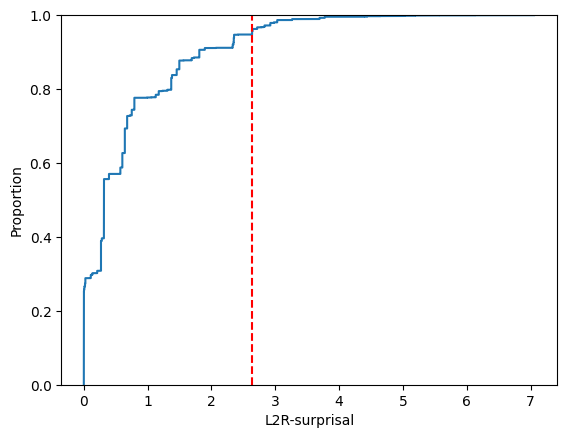

In [ ]:
import seaborn as sns
sns.ecdfplot(bi_df["L2R-surprisal"])
plt.axvline(surp_cut, color="red", ls="--"); plt.show()

Sometimes the two directions have slightly different surprisal distributions.
Overlaying them helps ensure the chosen cutoff works for both.
* If the two curves overlap almost perfectly, one threshold works for both;
* if the R2L curve lies to the left of L2R near the tail, R2L surprisal is generally smaller (lower the cutoff slightly or compute a separate R2L cutoff with the same `tail_frac`);
* conversely, if the R2L curve lies to the right, R2L surprisal is higher (use the maximum of the two thresholds to guarantee that a boundary fires only when both directions agree the token is extreme).

An even safer rule is $\text{cutoff} = \max(\text{surprisal cut left}, \text{surprisal cut right})$, ensuring symmetry at the cost of slightly fewer boundaries.

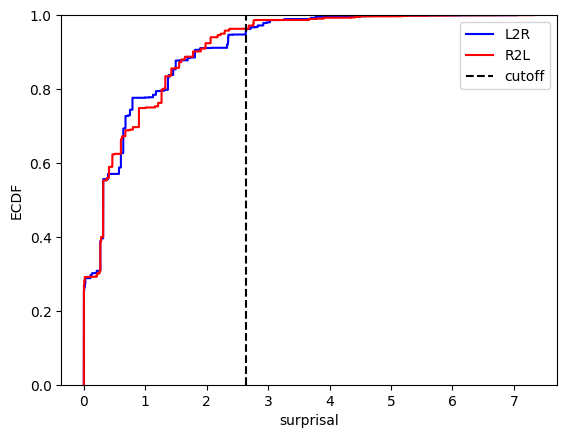

In [ ]:
sns.ecdfplot(bi_df["L2R-surprisal"], label="L2R", color="blue")
sns.ecdfplot(bi_df["R2L-surprisal"], label="R2L", color="red")
plt.axvline(surp_cut, color="black", ls="--", label="cutoff")
plt.legend(); plt.xlabel("surprisal"); plt.ylabel("ECDF"); plt.show()

#### Choosing tokenization direction

The metric values we obtain are computed twice—once with a left context (L2R) and once with a right context (R2L). If the two directions produced truly different distributions, the per-token differences

$$
\Delta\text{surprisal} = s_\text{R2L} - s_\text{L2R}, \quad \Delta\text{entropy} = H_\text{R2L} - H_\text{L2R}
$$

would be systematically non-zero.

A quick paired t-test on the full surprisal vectors gives a *p*-value ≈ 1:

In [ ]:
from scipy.stats import ttest_rel
print(ttest_rel(bi_df["L2R-surprisal"], bi_df["R2L-surprisal"]))

TtestResult(statistic=np.float64(0.005646115866032647), pvalue=np.float64(0.9954950926394596), df=np.int64(64793))


On a normal distribution this suggests that the mean difference is vanishingly small.

If we suspect outliers, noisy Δ-values, or the distribution is skewed, we apply a non-parametric Wilcoxon test to the paired Δ-values after removing padding rows.

The Wilcoxon test: for given paired observations $(x_i,y_i)$, let
$$
\Delta_i = y_i - x_i,\qquad i=1,\dots,n .
$$
Remove the pairs for which $\Delta_i = 0$.  
For the remaining $m$ pairs:

$$
\begin{aligned}
r_i &= \text{rank}\!\bigl(|\Delta_i|\bigr)
      &&\text{(1 for the smallest absolute difference)},\\
s_i &= \operatorname{sgn}(\Delta_i)\in\{+1,-1\},\\
W   &= \sum_{i=1}^{m} s_i\,r_i .
\end{aligned}
$$

Under the null hypothesis $\mathrm{median}(\Delta)=0$, the distribution of $W$ is known; its two-sided $p$-value is the probability of obtaining $|W|$ at least as large as the observed sum of signed ranks.

In [ ]:
from scipy.stats import wilcoxon
core = bi_df[~bi_df["Token"].isin(["-1"])]
delta_s = core["R2L-surprisal"] - core["L2R-surprisal"]
delta_e = core["R2L-entropy"]   - core["L2R-entropy"]
print(wilcoxon(delta_s))
print(wilcoxon(delta_e))

WilcoxonResult(statistic=np.float64(795238054.0), pvalue=np.float64(1.665251217383166e-05))
WilcoxonResult(statistic=np.float64(1032755961.0), pvalue=np.float64(0.0004091266482131543))


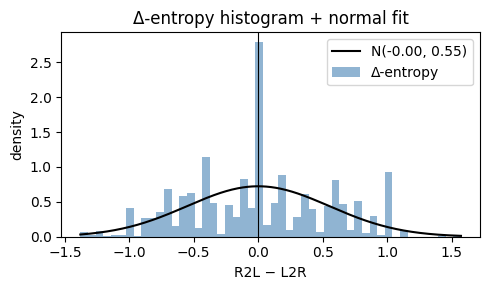

In [ ]:
from scipy.stats import norm
# Choose difference vector
delta_of = delta_e # change to delta_s for surprisal
# Detect label automatically
metric_name = "entropy" if np.all(delta_of == delta_e) else "surprisal"
# Fit normal
mu, sigma = norm.fit(delta_of)
plt.figure(figsize=(5, 3))
sns.histplot(delta_of, bins=50, stat="density",
             color="steelblue", edgecolor="none", alpha=.6,
             label=f"Δ-{metric_name}")
# Overlay normal curve
x = np.linspace(delta_of.min(), delta_of.max(), 400)
plt.plot(x, norm.pdf(x, mu, sigma), color="black", lw=1.5,
         label=f"N({mu:.2f}, {sigma:.2f})")
plt.axvline(0, color="black", lw=.8)
plt.title(f"Δ-{metric_name} histogram + normal fit")
plt.xlabel("R2L − L2R"); plt.ylabel("density")
plt.legend(); plt.tight_layout(); plt.show()

p ≫ 0.05: directions behave the same (median Δ close to 0);
p ≪ 0.05: one direction is systematically higher.

With *p*-values ≪ 0.05 on this slice, the right context makes tokens predictably more surprising/uncertain than the left.

On the histogram below, each bar's height is Δ for a token or a bin of tokens.
* Bars close to zero: directions agree;
* positive spikes: token is more surprising/uncertain when predicted from the right;
* negative spikes: token is more surprising/uncertain when predicted from the left;
* symmetric heavy tail: a few outlier tokens drive the difference.

When almost every bar hugs the baseline and Wilcoxon gives p ≫ 0.05, the two directions behave the same not just on average but at almost every position and segmentation boundaries remain stable whichever side we count. If histogram or Wilcoxon shows bias, pick the direction with lower median surprisal, or average both, before choosing the threshold.

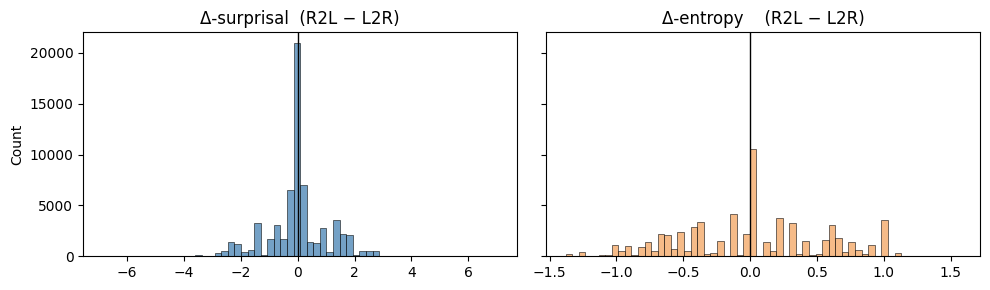

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
sns.histplot(delta_s, bins=60, ax=ax[0], color="steelblue")
sns.histplot(delta_e, bins=60, ax=ax[1], color="sandybrown")
ax[0].set_title("Δ-surprisal  (R2L − L2R)")
ax[1].set_title("Δ-entropy    (R2L − L2R)")
for a in ax: a.axvline(0, color="black", lw=1)
plt.tight_layout(); plt.show()

## `Tokenizer` Class

### Definition

In [ ]:
from collections import Counter

class Tokenizer:
    """
    Tokenizer that splits a sequence of integer tokens on padding and/or surprisal‐ or entropy‐based cuts.
    It consumes the DataFrame returned by `align_metrics`.
    Parameters (set at initialization):
        tokens (list): sequence of tokenized input data
        bi_df (pd.DataFrame): output of `align_metrics()`
        threshold (float): cut where surprisal exceeds this value
        variation (float): cut when the difference in entropy between successive tokens exceeds this value
        cut_on (tuple): a tuple of metrics to cut on e.g. ("surprisal",)
        direction (str): "left", "right", or "bidirectional" context evaluation
        output_frequencies (bool): if True, returns segments and a token-frequency Counter
        padding_token (...): token used to mark padding, e.g., -1
        boundary_token (...): if sequences have a boundary token and this parameter is set,
                              the tokenizer will insert boundaries around this token.
    Methods:
        get_segments -> list[list]: return segmented token sequences
        get_frequencies -> dict: return frequency of each segment (if enabled)
        set_threshold, set_variation, set_cut_on, set_direction: update parameters
        recompute: force segmentation
        summary: print config overview
    Attributes:
        boundaries_ (list): segmentation boundaries computed from bi_df
        segments_ (list): list of token segments
        frequencies_ (dict): unique segments and their frequencies
    """

    def __init__(self, tokens, bi_df, threshold=0.6, variation=0.3,
                 cut_on=("surprisal", "entropy"), direction="left",
                 output_frequencies=False, padding_token=-1, boundary_token=None):
        self._tokens             = tokens
        self._threshold          = threshold
        self._variation          = variation
        self._cut_on             = set(cut_on)
        self._direction          = direction
        self._output_frequencies = output_frequencies
        self._padding            = padding_token
        self._bound              = boundary_token

        # Validate and re‐index metrics
        if "Position" not in bi_df.columns:
            raise ValueError("bi_df must include a 'Position' column")
        required = {"Token", "L2R-surprisal", "R2L-surprisal", "L2R-entropy", "R2L-entropy"}
        if not required.issubset(bi_df.columns):
            missing = required - set(bi_df.columns)
            raise ValueError(f"bi_df missing columns: {missing}")
        self._df        = bi_df.set_index("Position", drop=False) # O(1)
        self._valid_idx = set(self._df.index)

        self.boundaries_  = []
        self.segments_    = []
        self.frequencies_ = None
        self._compute()

    def __repr__(self):
        return (f"<Tokenizer: {len(self._tokens)} tokens, "
                f"{len(self.segments_)} segments, cut_on={tuple(self._cut_on)}, "
                f"dir={self._direction}>")

    def _should_cut_on_surprisal(self, i):
        ls = self._df.at[i, "L2R-surprisal"]
        rs = self._df.at[i, "R2L-surprisal"]
        if self._direction == "left":
            return ls > self._threshold
        if self._direction == "right":
            return rs > self._threshold
        # bidirectional case
        return (ls > self._threshold) or (rs > self._threshold)

    def _should_cut_on_entropy(self, i):
        if i - 1 not in self._valid_idx:
            return False
        curr_l2r = self._df.at[i, "L2R-entropy"]
        prev_l2r = self._df.at[i-1, "L2R-entropy"]
        curr_r2l = self._df.at[i, "R2L-entropy"]
        prev_r2l = self._df.at[i-1, "R2L-entropy"]
        ldelta = abs(curr_l2r - prev_l2r)
        rdelta = abs(curr_r2l - prev_r2l)
        if self._direction == "left":
            return ldelta > self._variation
        if self._direction == "right":
            return rdelta > self._variation
        return (ldelta > self._variation) or (rdelta > self._variation)

    def _compute(self):
        L = len(self._tokens)
        cuts = {0, L}

        # cut around padding runs
        i = 0
        while i < L:
            if self._tokens[i] == self._padding:
                cuts.add(i)
                while i < L and self._tokens[i] == self._padding:
                    i += 1
                cuts.add(i)
            else:
                i += 1

        # cut at all boundary tokens
        if self._bound is not None:
            for j, tok in enumerate(self._tokens):
                if tok == self._bound and tok != self._padding:
                    cuts.add(j)
                    cuts.add(j+1)

        # metric‐based cuts only at valid indices
        for k in self._valid_idx:
            if 0 <= k < L and self._tokens[k] != self._padding:
                if "surprisal" in self._cut_on and self._should_cut_on_surprisal(k):
                    cuts.add(k)
                if "entropy"   in self._cut_on and self._should_cut_on_entropy(k):
                    cuts.add(k)

        # build sorted boundaries
        self.boundaries_ = sorted(cuts)

        # slice into segments, drop any that still contain padding
        segs = []
        for a, b in zip(self.boundaries_, self.boundaries_[1:]):
            chunk = self._tokens[a:b]
            if chunk and self._padding not in chunk:
                segs.append(chunk)
        self.segments_ = segs

        # frequencies if requested
        if self._output_frequencies:
            self.frequencies_ = dict(Counter(map(tuple, segs)).most_common())
        else:
            self.frequencies_ = None

    # Parameter setters
    def set_threshold(self, v):
        self._threshold = v; self._compute()
    def set_variation(self, v):
        self._variation = v; self._compute()
    def set_cut_on(self, c):
        self._cut_on = set(c); self._compute()
    def set_direction(self, d):
        if d not in ("left", "right", "bidirectional"):
            raise ValueError("direction must be 'left', 'right', or 'bidirectional'")
        self._direction = d; self._compute()

    def get_segments(self):
        return self.segments_
    def get_frequencies(self):
        if self.frequencies_ is None:
            self._output_frequencies = True
            self._compute()
        return self.frequencies_

    def summary(self):
        print("Tokenizer Configuration:")
        print(f"  Threshold:          {self._threshold}")
        print(f"  Variation:          {self._variation}")
        print(f"  Direction:          {self._direction}")
        print(f"  Cut On:             {tuple(self._cut_on)}")
        print(f"  Padding Token:      {self._padding}")
        print(f"  Output Frequencies: {self._output_frequencies}")
        print(f"  Num Segments:       {len(self.segments_)}")
        if self.frequencies_:
            print(f"  Unique Segments:    {len(self.frequencies_)}")

    def recompute(self):
        self._compute()

### Test

In [ ]:
def test_tokenizer():
    """padding removal, boundary‐token isolation, bidirectional surprisal cuts,
    correct use of the metrics DataFrame subset, segment ordering and integrity"""
    toks = [-1, -1, 10, 10, 11, 0, 20, 20, 30, -1]
    rows = []
    for i, t in enumerate(toks):
        if t == -1:
            continue
        # high L2R-surprisal only for 11
        l2r_s = 1.0 if t == 11 else 0.1
        # high R2L-surprisal **only for the FIRST 20 (i == 6)**
        r2l_s = 1.0 if (t == 20 and i == 6) else 0.1
        rows.append({
            "Position": i, "Token": t,
            "L2R-surprisal": l2r_s, "R2L-surprisal": r2l_s,
            "L2R-entropy": .05,     "R2L-entropy": .05,
        })
    df = pd.DataFrame(rows)

    tz = Tokenizer(
        toks, df,
        threshold=.5,
        variation=1.0,
        cut_on=("surprisal",),
        direction="bidirectional",
        padding_token=-1,
        boundary_token=0
    )
    segs = tz.get_segments()

    # exact gold segmentation
    gold = [[10, 10], [11], [0], [20, 20, 30]]
    assert segs == gold, f"Unexpected segments: {segs}"
    # padding removed
    flat = [tok for seg in segs for tok in seg]
    assert -1 not in flat
    # boundary token isolated
    assert [0] in segs
    # high-surprisal tokens start their own segments
    assert segs[1] == [11]
    # metrics dataframe was sparse (no rows for −1) – still worked
    assert set(df["Position"]).issubset(range(len(toks)))
test_tokenizer()

### Example

Provide desired smoothing, n-gram size and minimum unique signals to get `tokens`, `bi_df` for input into a tokenizer

In [ ]:
# Get a DF, provide smoothing, n for n-gram, direction
def prepare_tokenizer(df, moo, n, min_signals=1):
    tokens = Preprocessor(min_signals=1, n_pad=n, padding=-1).process(df, shuffle=True) # Don't set min_signals if the DataFrame is already capped!
    left_ngram = Ngram(n=n, smoothing_constant=moo, l2r=True)
    left_ngram.train(tokens)
    right_ngram = Ngram(n=n, smoothing_constant=moo, l2r=False)
    right_ngram.train(tokens)
    bi_df = align_metrics(tokens=tokens, left_ngram=left_ngram, right_ngram=right_ngram, metrics=('entropy','surprisal'))
    return tokens, bi_df

In [ ]:
def tokenizer_spit(tokens, bi_df, cut_on=("entropy", "surprisal"), threshold=0.6, variation=0.3, direction="left", bound=None):
    test_tokenizer = Tokenizer(tokens, bi_df, cut_on=cut_on, threshold=threshold, variation=variation, direction=direction, output_frequencies=True, boundary_token=bound)
    test_seg, test_tok = test_tokenizer.get_segments(), test_tokenizer.get_frequencies()
    print(f'Segmentation on {cut_on} output: {test_seg}')
    print(f'Found {len(test_tok)} unique tokens: {test_tok}')
    return test_seg, test_tok

### One more test

In [ ]:
def test_segmentation():
    tokens, bi_df = prepare_tokenizer(my_df, moo=0.0000001, n=3, min_signals=6)
    test_seg, _ = tokenizer_spit(tokens, bi_df, cut_on=("surprisal",), threshold=0.9, direction='left', bound=0)
    flat_a = [tok for seg in test_seg for tok in seg]        # flatten the 1-st list
    flat_b = [tok for tok in tokens if tok != -1]          # skip padding in 2-nd
    assert flat_a == flat_b, "flatten(a) ≠ b without −1s"
    # Return exactly the set of signals
    test_seg, _ = tokenizer_spit(tokens, bi_df, cut_on=("surprisal",), threshold=1000, direction='left', bound=None)
    # Return exactly the vocabulary
    test_seg, _ = tokenizer_spit(tokens, bi_df, cut_on=("surprisal",), threshold=-3, direction='left', bound=None)
test_segmentation()

Segmentation on ('surprisal',) output: [[4, 4, 4, 4, 4, 4, 4], [0], [9, 9, 9, 9, 9, 9, 9], [1], [0], [12], [1], [0], [12, 12, 12, 12, 12], [11], [1], [0], [4, 4, 4], [0], [9, 9, 9, 9, 9, 9, 9], [1], [0], [12], [4], [0], [12, 12, 12, 12, 12, 12], [5], [0], [9], [4, 4, 4, 4, 4, 4, 4], [0], [12], [1], [0], [12], [1], [0], [4, 4, 4, 4], [0], [12, 12, 12, 12, 12, 12, 12, 12], [0], [4, 4, 4, 4, 4, 4, 4], [0], [9], [4, 4, 4, 4, 4, 4, 4], [0], [12], [1], [0], [12, 12, 12, 12, 12, 12], [1, 1], [0], [12, 12, 12, 12, 12, 12], [1, 1], [0], [9, 9, 9, 9, 9, 9, 9], [1], [0], [12], [1], [0], [12, 12, 12, 12, 12, 12, 12, 12], [0], [12, 12, 12, 12, 12, 12], [1, 1], [0], [12, 12, 12, 12, 12, 12], [1, 1], [0], [12, 12, 12], [0], [1], [4], [0], [12], [4], [4, 4], [0], [12], [1], [0], [12], [9, 9, 9, 9, 9, 9], [0], [9, 9, 9, 9, 9, 9, 9], [1], [0], [9, 9, 9], [4, 4, 4, 4, 4], [0], [1, 1], [0], [12], [9, 9, 9, 9, 9, 9], [0], [9, 9, 9], [4, 4, 4, 4], [6], [0], [12, 12, 12], [0], [9, 9, 9], [4], [9, 4, 4, 4], [

# Evaluation

### Entropy/surprisal influence on segmentation outcomes

In [ ]:
entropy_vars = np.linspace(-1, 1.6, 16)
surp_thresholds = np.linspace(-1, 2.6, 16)

#### Vocabulary size vs. Surprisal

In [ ]:
def vocab_vs_surprisal(tokens, bi_df, thresholds):
    sizes = []
    for t in thresholds:
        tok = Tokenizer(tokens, bi_df, threshold=t, variation=1e9,  # disable entropy
                        cut_on=("surprisal",), direction="left", output_frequencies=True)
        sizes.append(len(tok.get_frequencies()))
    return sizes

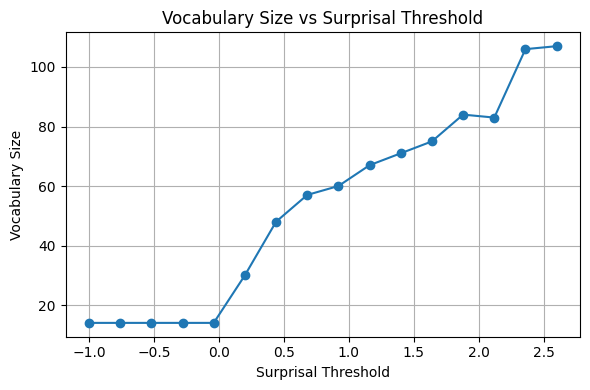

In [ ]:
sizes_surp = vocab_vs_surprisal(tokens, bi_df, surp_thresholds)

plt.figure(figsize=(6, 4))
plt.plot(surp_thresholds, sizes_surp, marker='o')
plt.title("Vocabulary Size vs Surprisal Threshold")
plt.xlabel("Surprisal Threshold")
plt.ylabel("Vocabulary Size")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Vocabulary size vs. Entropy

In [ ]:
def vocab_vs_entropy(tokens, bi_df, variations):
    sizes = []
    for v in variations:
        tok = Tokenizer(tokens, bi_df, threshold=1e9,  # disable surprisal
                        variation=v, cut_on=("entropy",), direction="left", output_frequencies=True)
        sizes.append(len(tok.get_frequencies()))
    return sizes

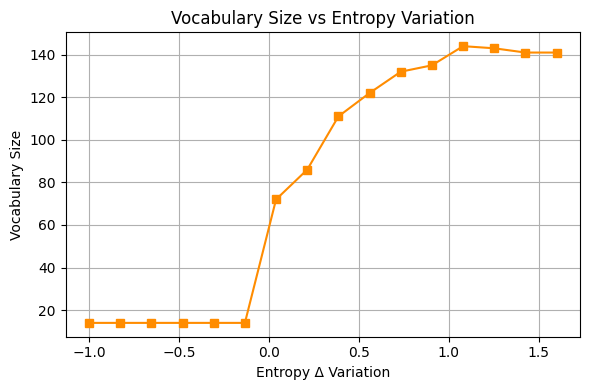

In [ ]:
sizes_entropy = vocab_vs_entropy(tokens, bi_df, entropy_vars)

plt.figure(figsize=(6, 4))
plt.plot(entropy_vars, sizes_entropy, marker='s', color='darkorange')
plt.title("Vocabulary Size vs Entropy Variation")
plt.xlabel("Entropy Δ Variation")
plt.ylabel("Vocabulary Size")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Tokens per Signal vs. Surprisal

In [ ]:
def segments_per_signal_surprisal(tokens, bi_df, thresholds, original_signal_count):
    avg_segs = []
    for t in thresholds:
        tok = Tokenizer(tokens, bi_df, threshold=t, variation=1e9,
                        cut_on=("surprisal",), direction="left")
        segs = tok.get_segments()
        avg_segs.append(len(segs) / original_signal_count)
    return avg_segs

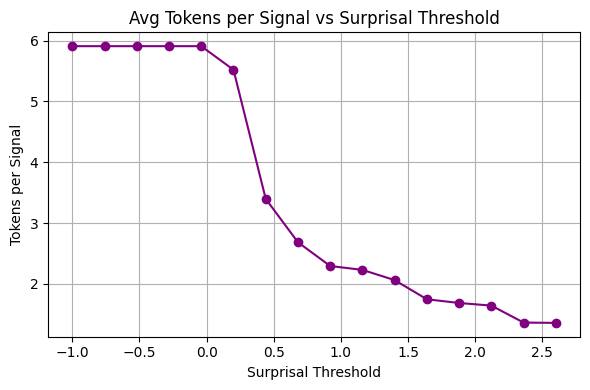

In [ ]:
original_signal_count = len(my_df)

avg_tokens_surp = segments_per_signal_surprisal(tokens, bi_df, surp_thresholds, original_signal_count)

plt.figure(figsize=(6, 4))
plt.plot(surp_thresholds, avg_tokens_surp, marker='o', color='purple')
plt.title("Avg Tokens per Signal vs Surprisal Threshold")
plt.xlabel("Surprisal Threshold")
plt.ylabel("Tokens per Signal")
plt.grid(True)
plt.tight_layout()
plt.show()

#### Tokens per Signal vs. Entropy

In [ ]:
def segments_per_signal_entropy(tokens, bi_df, variations, original_signal_count):
    seg_counts = []
    for v in variations:
        tok = Tokenizer(tokens, bi_df, threshold=1e9,  # disable surprisal
                        variation=v, cut_on=("entropy",), direction="left")
        segs = tok.get_segments()
        seg_counts.append(len(segs) / original_signal_count)
    return seg_counts

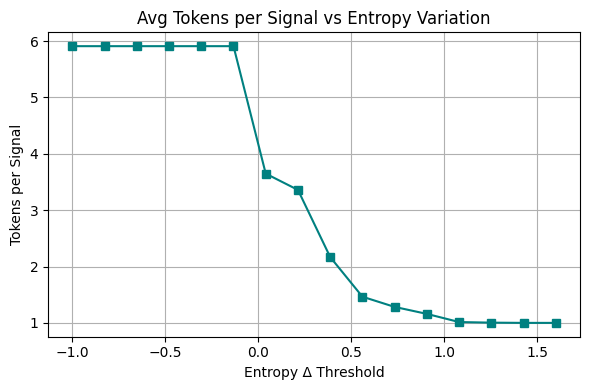

In [ ]:
avg_tokens_entropy = segments_per_signal_entropy(tokens, bi_df, entropy_vars, original_signal_count)

plt.figure(figsize=(6, 4))
plt.plot(entropy_vars, avg_tokens_entropy, marker='s', color='teal')
plt.title("Avg Tokens per Signal vs Entropy Variation")
plt.xlabel("Entropy Δ Threshold")
plt.ylabel("Tokens per Signal")
plt.grid(True)
plt.tight_layout()
plt.show()

### Exploratory diagnostics for a given setup

In [ ]:
tz = Tokenizer(tokens, bi_df, cut_on=("surprisal",), output_frequencies=True, boundary_token=None)

#### Distribution over segment length

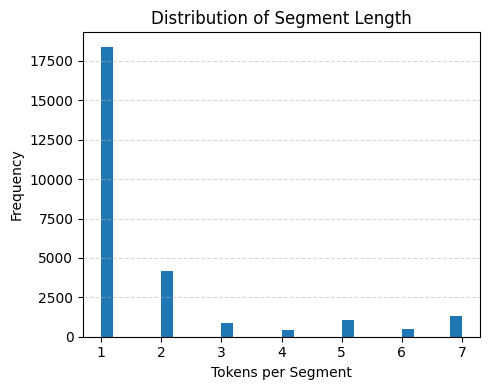

In [ ]:
def plot_segment_length_distribution(tokenizer, bins=30):
    seg_lengths = [len(s) for s in tokenizer.get_segments()]
    plt.figure(figsize=(5, 4))
    plt.hist(seg_lengths, bins=bins)
    plt.title("Distribution of Segment Length")
    plt.xlabel("Tokens per Segment")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout(); plt.show()
plot_segment_length_distribution(tz, bins=30)

#### Zipfian log distribution

* If the segmentation yields a Zipf-like distribution, the curve will be roughly a straight line on the log-log plot.
* If the tail drops off too quickly, the segmentation is creating too many rare segments, most appearing once or twice.
* If the slope is shallow, there are few segment types and most data is crammed into a small set of very frequent segments.

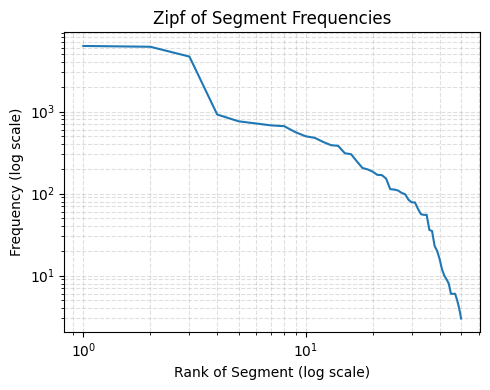

In [ ]:
def plot_zipf_distribution(tokenizer):
    rank = np.arange(1, len(tokenizer.get_frequencies()) + 1)
    plt.figure(figsize=(5, 4))
    plt.loglog(rank, sorted(tokenizer.get_frequencies().values(), reverse=True))
    plt.title("Zipf of Segment Frequencies")
    plt.xlabel("Rank of Segment (log scale)")
    plt.ylabel("Frequency (log scale)")
    plt.grid(True, which="both", ls="--", alpha=0.4)
    plt.tight_layout()
    plt.show()
plot_zipf_distribution(tz)

#### Directional asymmetry: Δ-Surprisal vs Δ-Entropy

How to read the cloud:
* Low-low: very predictable tokens in highly certain contexts (e.g. a fixed delimiter),
* High surprisal but low entropy: the model was confident yet got a rare outcom,
* Low surprisal but high entropy: context was uncertain, but this token was still relatively common,
* High-high: rare tokens in uncertain contexts; often boundary areas or data sparsity,

ValueError: Unknown label type: continuous. Maybe you are trying to fit a classifier, which expects discrete classes on a regression target with continuous values.

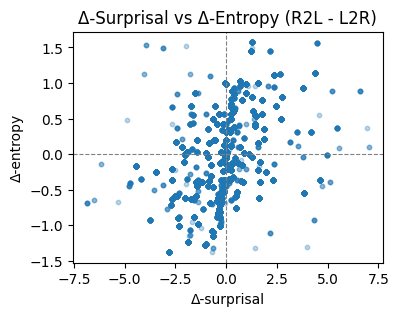

In [ ]:
def plot_surprisal_entropy_delta(df, alpha=.3):
    x = df["delta-surprisal"]
    y = df["delta-entropy"]
    plt.figure(figsize=(4,3))
    plt.scatter(x, y, alpha=alpha, s=10)
    plt.title("Δ-Surprisal vs Δ-Entropy (R2L - L2R)")
    plt.xlabel("Δ-surprisal")
    plt.ylabel("Δ-entropy")
    plt.axhline(0, color="gray", lw=0.8, linestyle="--")
    plt.axvline(0, color="gray", lw=0.8, linestyle="--")
    plt.tight_layout(); plt.show()
plot_surprisal_entropy_delta(bi_df)

# RUN ALL UNTIL HERE

# Testing outputs for Mutual Information

## A note on Mutual Information

### Mutual Information

Given two random variables $X$ and $Y$, mutual information $MI(X, Y)$ measures how much knowing the value of $X$ reduces uncertainty about $Y$, and vice versa. Mathematically, it is expressed as:
$$
MI(X, Y) = \sum_{x \in X} \sum_{y \in Y} p(x, y) \log \frac{p(x, y)}{p(x) p(y)}
$$

Mutual information is symmetric and always non-negative. Its upper bound is the minimum of the entropies of the two variables:
$$
0 ≤ MI(X, Y) ≤ min(E(X), E(Y)).
$$

If $X$ and $Y$ are independent, the joint probability distribution is exactly the product of the probability distributions of individual variables derived from their joint distribution:
$$
p(x, y) = p(x) \cdot p(y) \quad \text{for all } x, y.
$$
In this case, the mutual information is zero:
$$
MI(X, Y) = 0 \quad \text{if and only if} X ⊥ Y
$$
Conversely, if $MI(X, Y) = 0$, it implies that knowing $X$ provides no information about $Y$, the defining property of independence.

---

### Entropy

Entropy quantifies the average amount of information encoded by the possible outcomes of a random variable $X$ with a universe of outcomes $Ω$:
$$
0 ≤ E(X) ≤ log(|Ω|).
$$

**Deterministic distribution:**
If all of the probability mass is put on a single outcome, then the distribution is deterministic:
$$
E(X) = 0 \quad \text{if and only if} \quad ∃x∈Ω, Pr(X=x) = 1.
$$
**Uniform distribution:**
If $X$ encodes a uniform distribution (all outcomes are equally likely), then entropy is maximized:
$$
E(X) = log(|Ω|) \quad \text{if and only if} \quad ∀x∈Ω, Pr(X=x) = \frac{1}{|Ω|}.
$$
When X is a Boolean variable ($|Ω|=2$), for any other random variable Y, mutual information is capped at 1 bit.
$$
MI(X, Y) ≤ E(X) ≤ log(2) = 1 \text{ bit}.
$$

---

### Binary Quintuples

A sequence of events $x_1, x_2, …, x_i$ defines a random variable $X$ with universe $Ω = \{x_1, x_2, …, x_i\}$, where the probability of any element $x ∈ Ω$ is simply the frequency of its occurrence in the sequence:
$$
P(X = x) = \frac{\#\{i : x_i = x\}}{\#i} = \frac{\text{Count of } x \text{ in the sequence}}{\text{Total number of elements}}.
$$

In our case, each event is represented as a pair $(\text{image category}, \text{signal})$, which defines two distinct random variables:
* $M$ the sequence of image categories,
* $S$ the sequence of signals.

The image categories are uniformly distributed over $2^5$ possible classes, implying that the random variable $M$ carries exactly:
$$
H(M) = log_2(2^5) = 5 \text{ bits}
$$
of information. This means that **5 bits** is the theoretical maximum amount of information that can be inferred from the signals about the image categories. This upper bound is only achievable if the mapping between signals and categories is perfectly unambiguous (perfect class-to-signal correspondence). If noise and ambiguity is introduced, the information extracted from the signals will be strictly less than 5 bits.

---

### 1 bit of Information

A random variable $X$ over a universe $Ω$ encodes 1 bit of information if its universe is partitioned into two equally probable subsets:
$$
\sum_{x ∈ Ω_1} P(X=x) = \sum_{x ∈ Ω_2} P(X=x) = \frac{1}{2}.
$$
For example, given a sequence of events $x_1, x_2, …, x_i, …$, we extract 1 bit of information when we learn the Boolean sequence $Q(x_1), Q(x_2), …, Q(x_i)$ for a property $Q$ that hold s with probability $\frac{1}{2}$.

**Extension to $n$ parts:**
If the universe $Ω$ is partitioned into $n$ equal-probability regions, this corresponds to $log_2(n)$ bits of information.

## MI Evaluator: helper functions

From '[generate language](https://colab.research.google.com/drive/1yponF7f5RDbERxpwrc485tv51og_-6W_?usp=sharing#scrollTo=x9xb9TVjnFhK)'.

`test_feature()` does [TODO]

In [ ]:
from sklearn.metrics import mutual_info_score
from scipy.stats import entropy
import math, re
from itertools import combinations, permutations

df = my_df

signals, categories = df[['msg', 'cat']].to_numpy().T
signals = ["".join([f"/{i}/" for i in signal.split()]) for signal in signals]

def format_n(x, n=1):
  formatted_value = f"%.{math.ceil(-math.log(x, 10)) + n - 1}f" % x
  return formatted_value

# categories: list[?]
def get_entropy(categories):
  counter = Counter(categories)
  total   = counter.total()
  return entropy([(counter[x] / total) for x in counter])

# In all cases below, `feature_f` is a func[string, bool].
def test_feature(categories, signals=None, feature_f=None, features=None, normalized=False):
  assert (feature_f is None)     or (features is None)      # Either provide a feature function or directly provide features.
  assert (feature_f is not None) or (features is not None)  # Do not both provide a feature function and directly provide features.
  assert (feature_f is None)     == (signals is None)       # Provide signals if and only if you provide a feature function.

  if(features is None): features = [feature_f(signal) for signal in signals]

  #print(features, categories)
  #print(normalized, mutual_info_score(features, categories), get_entropy(features))
  if(normalized):
    e = get_entropy(features)
    if(e > 0.0): return mutual_info_score(features, categories) / e # output in [0, 1], proposition of the entropy of the features.
    else: return -1
  else: return mutual_info_score(features, categories) / math.log(2) # output in bits

NameError: name 'my_df' is not defined

In [ ]:
def prep_output_for_search(token_freq_dict):
    # Uses the frequency dict: only considers unique tokens
        # Wrap tokens in /x/ for clean input
        return [("/" + "//".join(map(str, token)) + "/", freq) for token, freq in token_freq_dict.items()]

Example:

In [ ]:
pattern = prep_output_for_search({(5,0):0})[0][0]
mi = test_feature(
            feature_f=(lambda signal, pat=pattern: re.search(pat,signal) is not None),
            signals=signals, categories=categories, normalized=True)
print(f"{pattern}: {format_n(mi, n=2)}")

NameError: name 'prep_output_for_search' is not defined

## Note on Maximizing MI

### Tokenization and Information Extraction

In the context of our experiment, the goal of tokenization is to maximize the information extracted from the sequence of signals while maintaining a structure that is semantically meaningful. Recall that each signal is associated with an image category, and there are exactly $2^5 = 32$ distinct image categories, setting a theoretical upper bound of **5 bits of information** that can be learned about the category from any signal, assuming a perfect one-to-one mapping and no noise.

Suppose a token segmentation allows us to reliably distinguish between two halves of the category space. This split represents a single bit of information since it narrows the category space by half. If further segmentation identifies subgroups within those halves, additional bits are gained. The full 5 bits are only achieved when each segment unambiguously maps to a single category.

We segments the signal sequence into discrete, contextualized tokens. Each segment represents a coherent unit of information, ideally corresponding to meaningful parts of the signal associated with the category it represents. The more precise the segmentation, the closer we will approach the theoretical 5-bit limit of category information.

We can frame the tokenization process as a form of **partitioning the signal space**:

* When we cut based on **surprisal**, we are segmenting signals at points of high unpredictability, possibly indicating shifts in semantic information.
* When we cut based on **entropy variation**, we identify regions where the signal's uncertainty dramatically changes, signaling new contexts.

Mutual Information (MI) can be used as a diagnostic to evaluate how much the tokenized segments reduce uncertainty about the image category. If tokenization is effective, learning the tokens provides significant information about the original category. Specifically:

* If the mutual information between the token sequence and the category labels is **close to 5 bits**, we know that the tokenization has preserved almost all category-specific information.
* If it is much **lower than 5 bits**, the tokenization process either over-segmented (too many fragments without semantic value) or under-segmented (grouped too much information in a single token).

---

### Measuring the Effectiveness of Tokenization

We can
1. measure the MI between the generated token sequences and the category labels to quantify the information gain. **T.BERNARD: What does this mean, exactly?**
2. plot the entropy of individual segments to observe if high-information parts are correctly isolated.
3. visualise the segment length frequencies to detect potential over-segmentation or under-segmentation.
4. analyze Zipf distributions of the token frequencies to assess redundancy or sparsity.

## Maximizing MI/nMI

### MI search on tokenization results

#### A
We can return the mutual information scores for all segments identified by a given tokenizer.

Normalizing Mutual Information by log-scaling very frequent tokens: an idea, [TODO] find a mathematically-grounded strategy.

We can consider:
* Pointwise Mutual Information
* Minimum Redundancy Maximum Relevance
* Mutual Information Feature Selection

In [ ]:
def search_on_tokenizer(token_freq_dict: dict):
    '''
    Compute MI for each subword token output by the tokenizer.
    Returns a DataFrame summarizing pattern, MI score, normalized MI.
    Returns the average MI, average nMI, and trivial tokens.
    '''
    def nmi_freq(mi, freq):
        '''With log scaling very frequent tokens have their MI downweighted.'''
        return mi / math.log(freq + 1) if freq > 0 else 0

    input = prep_output_for_search(token_freq_dict)
    output = []
    mi_sum = 0
    mi_fq_sum = 0
    count = 0
    trivials = set()

    for pattern, freq in input:
        mi = test_feature(
            feature_f=(lambda signal, pat=pattern: re.search(pat,signal) is not None),
            signals=signals,
            categories=categories,
            normalized=True
            )
        if mi == -1:
            trivials.add(pattern)
            continue
        norm_mi = nmi_freq(mi, freq)
        output.append({
            'Pattern': pattern,
            'MI': format_n(mi,2),
            'nMI': format_n(norm_mi,2),
            'Frequency': freq
        })

        mi_sum += mi
        mi_fq_sum += norm_mi
        count += 1

    avg_mi = mi_sum / count if count > 0 else -1
    avg_nmi = mi_fq_sum / count if count > 0 else -1

    return pd.DataFrame(output), avg_mi, avg_nmi, trivials

In [ ]:
print(search_on_tokenizer(tz.get_frequencies()))

(                         Pattern    MI    nMI  Frequency
0                            /1/  0.83  0.095       6295
1                           /12/  0.91   0.11       4673
2                         /1//1/  0.84   0.12        919
3                         /4//0/  0.87   0.13        759
4           /12//12//12//12//12/  0.91   0.14        714
5          /4//4//4//4//4//4//4/  0.83   0.13        677
6                       /12//12/  0.88   0.14        663
7                         /5//0/  0.77   0.12        559
8                            /9/  0.91   0.15        499
9                      /9//9//9/  0.90   0.15        477
10                        /1//0/  0.80   0.13        425
11                           /4/  0.86   0.14        389
12         /9//9//9//9//9//9//9/  0.85   0.14        381
13               /4//4//4//4//4/  0.86   0.15        310
14            /9//9//9//9//9//9/  0.85   0.15        302
15  /12//12//12//12//12//12//12/  0.89   0.16        246
16                          /1

#### B
The number of possible setups depends on the granularity of our approach. In practice, our exploration has shown tokens per signal for different set values of surprisal or entropy variation, where productive tokenization setups are situated between the high and low average token length plateaus. `get_span()` returns a span over which it is reasonable to scan the linear or logarithmic space.

In [ ]:
def get_span(vars, avg_tokens):
    assert len(vars) == len(avg_tokens), "lengths must match"
    span = list(zip(vars, avg_tokens))

    # Trim leading identical averages
    lead_avg = span[0][1]
    i = 1
    while i < len(span) and span[i][1] == lead_avg:
        i += 1
    trimmed = span[i-1:]  # keep one at the start

    # Trim trailing identical averages
    trail_avg = trimmed[-1][1]
    j = len(trimmed)-2
    while j >= 0 and trimmed[j][1] == trail_avg:
        j -= 1
    trimmed = trimmed[:j+2]  # keep one at the end

    return trimmed[0], trimmed[-1]

In [ ]:
def df_cat_ids(dataframe):
    """Returns the signals-categories dataframe with categories assigned an id."""
    df = dataframe[["msg", "cat"]].copy()
    df["cat_id"] = df["cat"]

    return df

#### C

Say we want to test a space of 10 values for $τ$ surprisal threshold and $ΔH$ entropy variation. Our tokenizer can have 3 directions and consider 3 metric setups $|\{τ, ΔH, τ⨁ΔH\}|×|\{\text{left, right, both}\}|$.

In the cases where we only check one metric, this leaves $2 \times 10 \times 3 = 60$ setups, when considering both metrics, the number grows to $1 \times 10 \times 10 \times 3 = 300$ setups.

Moreover, we may want to test at least 2 and 3-gram models, as well as a very high (~1 or 0.1) and a very low smoothing value (1e-6), increasing our search space to $2 \times 2 \times (60 + 300) = 1,440$ setups, nothing a computer cannot manage.

The issue is in representation. Ideally, we would report a table of every configuration that lets us:
* identifies tendencies (regions that tend to maximize MI/nMI);
* measure overlap between tokenizers (e.g. using Jaccard, KL on frequency distributions);
* or conversely, show segmentation distance $F_{dist}(A,B) = 1 - 2 \cdot \frac{|A⋂B|}{|A|+|B|}$ (A, B sets of pairs of indices);
* create visual aids: plots (|V| × threshold), distance heatmap for tokenizers, dendrograms...

and so on.

NOTE (to self, TODO): To compare L2R+R2L, we may have to shift R2L by +1 everywhere (change `Tokenizer` logic). Perhaps more reasonably, we may only compare within the same directionality class.

In the least, for certain segmentation setups, we want to extract the full vocabulary with per-token frequency counts and compare how much left-to-right, right-to-left, and combined tokenizers diverge.

## WIP

# Building precise `token:category` correspondence [to automate]

## Full category correspondence (for insight returned by top models)

### Single pattern-category correspondence

The relative frequency distribution for matched signals measures the proportion of each category among only those signals that match a given regex pattern.

$$
\text{Relative Frequency}(c_i) = \frac{\text{Count of } c_i \text{ among matches}}{\sum_{j=1}^{k} \text{Count of } c_j \text{ among matches}}
$$

Where:
- $c_i$ is a category with matched signals
- $k$ is the number of distinct matched categories

In other words:
$$
\text{Relative Frequency} = \frac{\text{Frequency of a category}}{\text{Total frequency of all matched categories}}
$$

In [ ]:
def pattern_category_distribution(pattern, signals, categories):
    '''
    Computes a relative frequency distribution of categories that correspond to signals matching the given regex pattern.
    Returns a dictionary mapping each matched category to its proportion among all matches.
    '''
    matches = [re.search(pattern, s) is not None for s in signals]
    # Build a subset of categories for which the pattern matched
    matched_cats = [cat for match, cat in zip(matches, categories) if match]
    counter = Counter(matched_cats)
    total = sum(counter.values())
    distribution = {cat: count / total for cat, count in counter.items()} if total > 0 else {}
    return distribution

In [ ]:
pattern = "/5//0/"
distribution = pattern_category_distribution(pattern, signals, categories)
print("Conditional category distribution for pattern", pattern)
print(sorted(distribution.items(), key=lambda item: item[1], reverse=True))

Conditional category distribution for pattern /5//0/
[('1 1 1 1 1', 0.49552772808586765), ('0 0 1 1 0', 0.2737030411449016), ('1 0 1 1 0', 0.13953488372093023), ('0 1 1 1 0', 0.08944543828264759), ('0 1 1 1 1', 0.0017889087656529517)]


### Full data pattern-category correspondence

DataFrame built from pattern-category distribution and heatmap of correspondences

In [ ]:
tokens, bi_df = prepare_tokenizer(my_df, moo=0.0000001, n=2, min_signals=1)
tokenizer = Tokenizer(tokens, bi_df, threshold=0.75, cut_on=("surprisal",), direction="left", output_frequencies=True)
freq_dict = tokenizer.get_frequencies()

pattern_list = prep_output_for_search(freq_dict) # for one tokenizer, for example
distribution_records = []

for pattern, _ in pattern_list:
    dist = pattern_category_distribution(pattern, signals, categories)
    distribution_records.append({'pattern': pattern, **dist})

df_distribution = pd.DataFrame(distribution_records).fillna(0)

In [ ]:
df_distribution

,pattern,1 1 1 1 1,1 1 1 1 0,1 1 1 0 1,1 1 1 0 0,1 1 0 1 1,1 1 0 1 0,1 1 0 0 1,1 1 0 0 0,1 0 1 1 1,...,0 1 0 0 1,0 1 0 0 0,0 0 1 1 1,0 0 1 1 0,0 0 1 0 1,0 0 1 0 0,0 0 0 1 1,0 0 0 1 0,0 0 0 0 1,0 0 0 0 0
0,/0/,0.033813,0.031128,0.030640,0.032593,0.032227,0.033691,0.028442,0.031982,0.030762,...,0.028687,0.027466,0.032471,0.031738,0.030518,0.036743,0.028931,0.032837,0.031006,0.031128
1,/12/,0.062613,0.057640,0.000000,0.000452,0.059675,0.062387,0.000452,0.059222,0.056962,...,0.000000,0.009042,0.053345,0.058770,0.000000,0.000000,0.053571,0.057188,0.056284,0.000000
2,/1/,0.000000,0.061239,0.060996,0.064885,0.000000,0.067072,0.056379,0.062697,0.000000,...,0.057108,0.054678,0.000243,0.000486,0.000243,0.002673,0.057594,0.003888,0.000000,0.011179
3,/1//1/,0.000000,0.119886,0.000000,0.126070,0.000000,0.131304,0.000476,0.093245,0.000000,...,0.000000,0.001427,0.000000,0.000000,0.000000,0.001427,0.000000,0.000951,0.000000,0.000000
4,/4/,0.000000,0.001246,0.000000,0.000415,0.000000,0.000000,0.095970,0.001246,0.001246,...,0.097632,0.081845,0.000000,0.043623,0.103448,0.118820,0.000000,0.000000,0.105526,0.090154
5,/12//12//12//12//12//12/,0.272906,0.248276,0.000000,0.000000,0.000000,0.000000,0.000985,0.000000,0.000000,...,0.000000,0.000000,0.000985,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,/1//1//1//1//1/,0.000000,0.000000,0.000000,0.000000,0.000000,0.392701,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002920,0.000000,0.000000
7,/4//4//4//4//4//4//4/,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.363368,0.000000,0.000000,0.000000,0.007386,0.047267
8,/12//12//12/,0.141327,0.128571,0.000000,0.000000,0.134694,0.002551,0.000510,0.020408,0.000000,...,0.000000,0.000510,0.065816,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,/5//0/,0.495528,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.273703,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot the DataFrame so that each row is a pattern and each column a category
heatmap_data = df_distribution.set_index('pattern')

# Dynamically adjust height based on number of patterns
num_patterns = heatmap_data.shape[0]
plt.figure(figsize=(12, max(1, 0.3 * num_patterns)))  # Adjust height scale as needed

sns.heatmap(heatmap_data, annot=False, cmap="viridis", cbar=True)
plt.title("Conditional Distribution of Categories for Each Pattern")
plt.xlabel("Category")
plt.ylabel("Pattern")
plt.tight_layout()
plt.show()

## "One Bit" correspondence [WIP 16.04]

### General distribution


In [ ]:
def overall_position_distribution(categories, position=0):
    '''
    Extracts the relevant bit at a specified position from all categories.
    Returns the relative frequency distribution as a dictionary.
    '''
    all_values = []
    for cat in categories:
        tokens = cat.split()
        if len(tokens) > position:
            all_values.append(tokens[position])
    freq = Counter(all_values)
    total = sum(freq.values())
    return {symbol: count / total for symbol, count in freq.items()} if total > 0 else {}

### Distribution on a given position

We can model the distribution of token positions 'conditioned' on /signals that satisfy a specific regex/ (only the categories linked to signals matching a given pattern, i.e. context-sensitively). Results are inherently biased by the regex; weak or very broad patterns can and will distort the distribution.

In [ ]:
import re
from collections import Counter

def pattern_position_distribution(pattern, signals, categories, position=0):
    '''
    Extracts tokens at a specified position from categories linked to signals matching a regex pattern.
    Returns their relative frequency distribution (dict).
    '''
    # Get indices where the pattern matches
    matches = [re.search(pattern, s) is not None for s in signals]

    # Forall matching signals split the corresponding cat and take the token at the given position (if exists)
    position_values = []
    for match, cat in zip(matches, categories):
        if match:
            tokens = cat.split()  # we have space-delimited tokens, TODO "robust" this
            if len(tokens) > position:
                position_values.append(tokens[position])

    # Count freqs
    freq = Counter(position_values)
    total = sum(freq.values())
    distribution = {symbol: count / total for symbol, count in freq.items()} if total > 0 else {}
    return distribution

### DEMO

In [ ]:
# Set these to check for correspondences to categories
pattern = "/5//0/"
pos = 3           # for 5 bits 0-4 positions
conditional_dist = pattern_position_distribution(pattern, signals, categories, position=pos)
baseline_dist = overall_position_distribution(categories, position=pos)

print(f"Baseline distribution at pos={pos}")
print(baseline_dist)
print()
print(f"Conditional distribution at pos={pos} for {pattern}")
print(conditional_dist)